Define functions to load in tables of varying depth

In [2]:
import pandas as pd
def filter_df(fname):
    # Load the entire DataFrame from a Parquet file
    df = pd.read_parquet(path + fname + '.parquet')

    for col in df.columns:
        if col[-1] in ("P", "A"):
            df[col] = df[col].astype('float32')

        if df[col].dtype.name in ['object', 'string']:
            df[col] = df[col].astype("string").astype('category')
            current_categories = df[col].cat.categories
            new_categories = current_categories.to_list() + ["Unknown"]
            new_dtype = pd.CategoricalDtype(categories=new_categories, ordered=True)
            df[col] = df[col].astype(new_dtype)

    return df

def depth1_feats(df):
    numeric_cols = df.select_dtypes(include=['number']).columns.tolist()
    numeric_cols.remove('case_id')
    numeric_cols.remove('num_group1')
    aggfeats = df.groupby('case_id')[numeric_cols].agg('sum').reset_index()

    notnum_cols = df.select_dtypes(exclude=['number']).columns.tolist()
    notnum_cols.append('case_id')
    filfeats = df[df['num_group1'] == 0]
    filfeats = filfeats.drop('num_group1', axis=1)
    filfeats = filfeats.filter(items=notnum_cols)
    return pd.merge(filfeats, aggfeats, how='left', on='case_id')

def depth2_feats(df):
    numeric_cols = df.select_dtypes(include=['number']).columns.tolist()
    numeric_cols.remove('case_id')
    numeric_cols.remove('num_group1')
    numeric_cols.remove('num_group2')
    aggfeats = df.groupby('case_id')[numeric_cols].agg('sum').reset_index()

    notnum_cols = df.select_dtypes(exclude=['number']).columns.tolist()
    notnum_cols.append('case_id')
    df = df[df['num_group1'] == 0]
    df = df[df['num_group2'] == 0]
    filterdf = df.drop(['num_group1', 'num_group2'], axis=1)
    filterdf = filterdf.filter(items=notnum_cols)
    return pd.merge(filterdf, aggfeats, how='left', on='case_id') 

In [10]:
def depth1_feats(df):
    # Filter first
    filtered_df = df[df['num_group1'] == 0]
    
    numeric_cols = filtered_df.select_dtypes(include=['number']).columns.tolist()
    numeric_cols.remove('case_id')
    numeric_cols.remove('num_group1')
    aggfeats = filtered_df.groupby('case_id')[numeric_cols].agg('sum').reset_index()
    
    notnum_cols = filtered_df.select_dtypes(exclude=['number']).columns.tolist()
    notnum_cols.append('case_id')
    filfeats = filtered_df.drop('num_group1', axis=1)
    filfeats = filfeats.filter(items=notnum_cols)
    
    return pd.merge(filfeats, aggfeats, how='left', on='case_id')

def depth2_feats(df):
    # Filter first
    filtered_df = df[(df['num_group1'] == 0) & (df['num_group2'] == 0)]
    
    numeric_cols = filtered_df.select_dtypes(include=['number']).columns.tolist()
    numeric_cols.remove('case_id')
    numeric_cols.remove('num_group1')
    numeric_cols.remove('num_group2')
    aggfeats = filtered_df.groupby('case_id')[numeric_cols].agg('sum').reset_index()
    
    notnum_cols = filtered_df.select_dtypes(exclude=['number']).columns.tolist()
    notnum_cols.append('case_id')
    filterdf = filtered_df.drop(['num_group1', 'num_group2'], axis=1)
    filterdf = filterdf.filter(items=notnum_cols)
    
    return pd.merge(filterdf, aggfeats, how='left', on='case_id')

Load in base table

In [3]:
path = '/rds/general/user/ms2524/home/amexproject/parquet_files/train/train_'
base_cba = pd.read_parquet(path + "base.parquet", columns=['case_id','WEEK_NUM','target'])

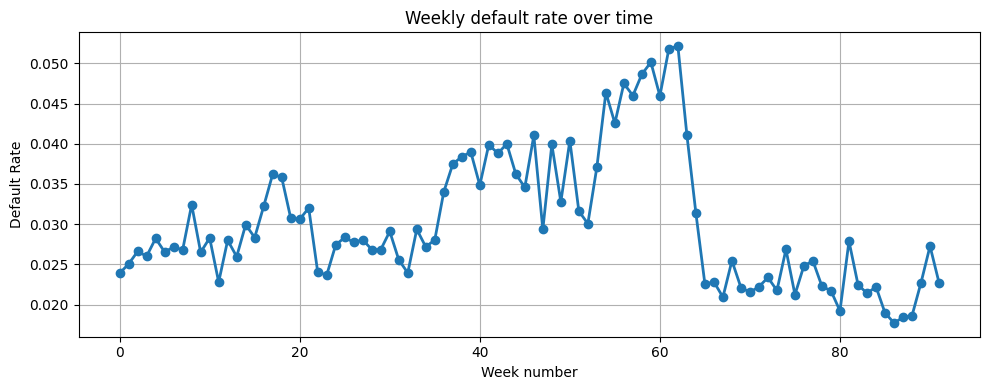

In [4]:
import pandas as pd
import matplotlib.pyplot as plt

weekly_defaults = (
    base_cba
    .groupby('WEEK_NUM')['target']
    .mean()
    .reset_index()
)

plt.figure(figsize=(10, 4))
plt.plot(weekly_defaults['WEEK_NUM'], weekly_defaults['target'], marker='o', linewidth=2)
plt.title('Weekly default rate over time')
plt.xlabel('Week number')
plt.ylabel('Default Rate')
plt.grid(True)
plt.tight_layout()
plt.savefig('../Figures/weekly_default_rate.pdf', format='pdf')
plt.show()


## Depth = 2

### Credit Bureua A

In [11]:
all_chunks = []
for id in range(11):
    df = filter_df(f'credit_bureau_a_2_{id}')
    processed = depth2_feats(df)
    all_chunks.append(processed)

# Concatenate everything at once
tmp = pd.concat(all_chunks, ignore_index=True)

# Merge with base
data_cba = pd.merge(base_cba, tmp, how="left", on="case_id")


### Previous application

In [12]:
data_appl = pd.merge(
    base_cba,
    depth2_feats(filter_df('applprev_2')),
    how="left",
    on="case_id"
)


## Depth = 1

### Credit Bureua A

In [13]:
data_cba = pd.merge(
    data_cba,
    depth1_feats(pd.concat([filter_df(f'credit_bureau_a_1_{id}') for id in range(4)])),
    how="left",
    on="case_id"
)

### Previous application

In [14]:
data_appl = pd.merge(
    data_appl,
    depth1_feats(pd.concat([filter_df(f'applprev_1_{id}') for id in range(2)])),
    how="left",
    on="case_id"
)


### Train person

In [15]:
data_person_1_train = pd.merge(
    base_cba,
    depth1_feats(filter_df('person_1')),
    how="left",
    on="case_id"
)

## Depth = 0

### Train Static

In [16]:
columns_to_keep = [
    'case_id', 'annuity_780A', 'credamount_770A', 'disbursedcredamount_1113A', 
    'eir_270L', 'pmtnum_254L', 'lastst_736L', 'totalsettled_863A', 
    'numrejects9m_859L', 'currdebt_22A'
]

data_static_train = pd.merge(
    base_cba,
    pd.concat([
        filter_df(f'static_0_{id}')[columns_to_keep]
        for id in range(2)
    ], ignore_index=True),
    how="left",
    on="case_id"
)

## Feature selection 

In [17]:
for col in data_cba.columns:
    if col.endswith('D'):
        data_cba[col] = pd.to_datetime(data_cba[col], errors='coerce')


for col in data_cba.select_dtypes(include=['object']).columns:
    data_cba[col] = data_cba[col].astype('category')

for col in data_appl.columns:
    if col.endswith('D'):
        data_appl[col] = pd.to_datetime(data_appl[col], errors='coerce')

for col in data_appl.select_dtypes(include=['object']).columns:
    data_appl[col] = data_appl[col].astype('category')

for col in data_static_train.columns:
    if col.endswith('D'):
        data_static_train[col] = pd.to_datetime(data_static_train[col], errors='coerce')

for col in data_static_train.select_dtypes(include=['object']).columns:
    data_static_train[col] = data_static_train[col].astype('category')

for col in data_person_1_train.columns:
    if col.endswith('D'):
        data_person_1_train[col] = pd.to_datetime(data_person_1_train[col], errors='coerce')

for col in data_person_1_train.select_dtypes(include=['object']).columns:
    data_person_1_train[col] = data_person_1_train[col].astype('category')

In [18]:
import numpy as np
cb_features = ['case_id', 'WEEK_NUM','pmts_dpd_1073P', 'pmts_dpd_303P', 'dpdmax_139P', 'numberofoverdueinstlmax_1039L', 'numberofoverdueinstls_725L', 'collaterals_typeofguarante_359M', 'classificationofcontr_400M', 'subjectrole_93M', 'target']
data1_cba=data_cba[cb_features]
data1_cba = data1_cba.copy()
data1_cba.replace(['na', 'NaN', '#########'], np.nan, inplace=True)

applprev_features = ['case_id', 'WEEK_NUM','maxdpdtolerance_577P', 'cacccardblochreas_147M', 'rejectreason_755M','target']
data1_appl=data_appl[applprev_features]
data1_appl = data1_appl.copy()
data1_appl.replace(['na', 'NaN', '#########'], np.nan, inplace=True)

static_features = ['case_id', 'WEEK_NUM','annuity_780A', 'credamount_770A', 'disbursedcredamount_1113A', 'eir_270L', 'pmtnum_254L', 'lastst_736L']
data_static_train_1 = data_static_train[static_features]
data_static_train_1 = data_static_train_1.copy()
data_static_train_1.replace(['na', 'NaN', '#########'], np.nan, inplace=True)

person_features = ['case_id', 'WEEK_NUM','personindex_1023L', 'persontype_1072L', 'persontype_792L', 'empladdr_zipcode_114M', 'incometype_1044T', 'safeguarantyflag_411L', 'type_25L','target']
data_person_1_train_1 = data_person_1_train[person_features]
data_person_1_train_1 = data_person_1_train_1.copy()
data_person_1_train_1.replace(['na', 'NaN', '#########'], np.nan, inplace=True)

In [19]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder
import pandas as pd
import numpy as np


# Split by WEEK_NUM into equal segments
def split_by_week(df, n):
    min_week = df["WEEK_NUM"].min()
    max_week = df["WEEK_NUM"].max()
    bins = np.linspace(min_week, max_week + 1, n + 1, dtype=int)

    segments = {}
    for i in range(n):
        lower = bins[i]
        upper = bins[i + 1]
        key = f"split_{i}"
        segments[key] = df[(df["WEEK_NUM"] >= lower) & (df["WEEK_NUM"] < upper)].copy()

    return segments

def preprocess_split(train_df, test_df):
    exclude_columns = {'case_id', 'WEEK_NUM', 'target'}
    numcols = []
    catcols = []

    # Separate numeric and categorical columns
    for col in train_df.columns:
        if col in exclude_columns:
            continue
        if pd.api.types.is_numeric_dtype(train_df[col]):
            numcols.append(col)
        elif pd.api.types.is_object_dtype(train_df[col]) or pd.api.types.is_categorical_dtype(train_df[col]):
            catcols.append(col)

    # Impute numeric columns
    for col in numcols:
        if train_df[col].isnull().any():
            strategy = 'median' if abs(train_df[col].skew()) > 0.5 else 'mean'
            imputer = SimpleImputer(strategy=strategy)
            train_df[[col]] = imputer.fit_transform(train_df[[col]])
            test_df[[col]] = imputer.transform(test_df[[col]])

    # Handle categorical columns: fill NA with "Unknown"
    for col in catcols:
        for df in [train_df, test_df]:
            if "Unknown" not in df[col].cat.categories:
                df[col] = df[col].cat.add_categories("Unknown")

        # Fill missing values
        train_df[col] = train_df[col].fillna("Unknown")
        test_df[col] = test_df[col].fillna("Unknown")

    # Ordinal encode
    encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
    train_df[catcols] = encoder.fit_transform(train_df[catcols])
    test_df[catcols] = encoder.transform(test_df[catcols])

    return train_df, test_df

def preprocess_all_segments(df, n):
    segments = split_by_week(df, n)
    base_train = segments["split_0"].copy()
    processed_segments = {}

    for key, segment_df in segments.items():
        train_proc, test_proc = preprocess_split(base_train.copy(), segment_df.copy())
        processed_segments[key] = test_proc

    return processed_segments

In [20]:
def merge_all_segments(cba_splits, static_splits, person_splits, appl_splits):
    merged_segments = {}

    drop_cols = ['WEEK_NUM', 'target']

    for split_name in cba_splits:
        cba = cba_splits[split_name]
        static = static_splits[split_name].drop(columns=[col for col in drop_cols if col in static_splits[split_name].columns])
        person = person_splits[split_name].drop(columns=[col for col in drop_cols if col in person_splits[split_name].columns])
        appl = appl_splits[split_name].drop(columns=[col for col in drop_cols if col in appl_splits[split_name].columns])

        merged = cba.merge(static, on="case_id", how="inner") \
                    .merge(person, on="case_id", how="inner") \
                    .merge(appl, on="case_id", how="inner")

        merged_segments[split_name] = merged

    return merged_segments


In [21]:
n_segments = 40

cba_proc = preprocess_all_segments(data1_cba, n=n_segments)
static_proc = preprocess_all_segments(data_static_train_1, n=n_segments)
person_proc = preprocess_all_segments(data_person_1_train_1, n=n_segments)
appl_proc = preprocess_all_segments(data1_appl, n=n_segments)

final_segments = merge_all_segments(cba_proc, static_proc, person_proc, appl_proc)

/rds/general/user/ms2524/ephemeral/ipykernel_402521/2189584386.py:33: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  elif pd.api.types.is_object_dtype(train_df[col]) or pd.api.types.is_categorical_dtype(train_df[col]):
/rds/general/user/ms2524/ephemeral/ipykernel_402521/2189584386.py:33: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  elif pd.api.types.is_object_dtype(train_df[col]) or pd.api.types.is_categorical_dtype(train_df[col]):
/rds/general/user/ms2524/ephemeral/ipykernel_402521/2189584386.py:33: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  elif pd.api.types.is_object_dtype(train_df[col]) or pd.api.types.is_categorical_dtype(train_df[col]):
/rds/general/user/ms2524/ephemeral/ip

In [22]:
def run_bandit_epsilon_greedy_n1(final_segments, threshold=0.03, epsilon=0.1):
    """
    Standard epsilon-greedy bandit (n=1):
    - Train on previously approved + epsilon fraction of rejected applicants.
    - Use previous split as training set each round.
    """
    from sklearn.linear_model import LogisticRegression
    from sklearn.pipeline import make_pipeline
    from sklearn.preprocessing import StandardScaler
    from sklearn.metrics import roc_auc_score, recall_score, confusion_matrix
    import pandas as pd
    import numpy as np

    results = []
    exclude_cols = {'case_id', 'WEEK_NUM', 'target'}
    features = [col for col in final_segments['split_0'].columns if col not in exclude_cols]
    sorted_keys = sorted(final_segments.keys(), key=lambda x: int(x.split('_')[-1]))

    for t in range(1, len(sorted_keys)):
        train_key = sorted_keys[t - 1]
        test_key = sorted_keys[t]

        train_segment = final_segments[train_key]
        test_segment = final_segments[test_key]

        X_train_full = train_segment[features]
        y_train_full = train_segment["target"]
        X_test = test_segment[features]
        y_test = test_segment["target"]

        # Simulate approval decisions on training data
        temp_model = make_pipeline(StandardScaler(), LogisticRegression(max_iter=1000))
        temp_model.fit(X_train_full, y_train_full)
        y_proba_train = temp_model.predict_proba(X_train_full)[:, 1]

        approved_mask = y_proba_train < threshold
        rejected_mask = ~approved_mask

        X_approved = X_train_full[approved_mask]
        y_approved = y_train_full[approved_mask]

        # ε-greedy: sample epsilon fraction of rejected applicants
        rejected_indices = X_train_full[rejected_mask].index
        n_explore = int(epsilon * len(rejected_indices))
        explore_indices = np.random.choice(rejected_indices, size=n_explore, replace=False) if n_explore > 0 else []

        X_explore = X_train_full.loc[explore_indices]
        y_explore = y_train_full.loc[explore_indices]

        # Combine approved + explored
        X_train = pd.concat([X_approved, X_explore], ignore_index=True)
        y_train = pd.concat([y_approved, y_explore], ignore_index=True)

        # Train final model
        model = make_pipeline(StandardScaler(), LogisticRegression(max_iter=1000))
        model.fit(X_train, y_train)

        # Evaluate on current test split
        y_pred_proba = model.predict_proba(X_test)[:, 1]
        y_pred = (y_pred_proba >= threshold).astype(int)
        recall = recall_score(y_test, y_pred)
        tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
        specificity = tn / (tn + fp)
        auc = roc_auc_score(y_test, y_pred_proba)
        accept_mask = y_pred_proba < threshold

        results.append({
            "segment": test_key,
            "segment_num": int(test_key.split("_")[1]),
            "type": f"bandit_eps{epsilon}_n1",
            "auc": auc,
            "recall": recall,
            "specificity": specificity,
            "actual_default_rate": y_test.mean(),
            "predicted_default_rate": y_pred_proba.mean(),
            "accept_rate": accept_mask.mean(),
            "tn": tn,
            "fp": fp,
            "fn": fn,
            "tp": tp
        })

    return pd.DataFrame(results)


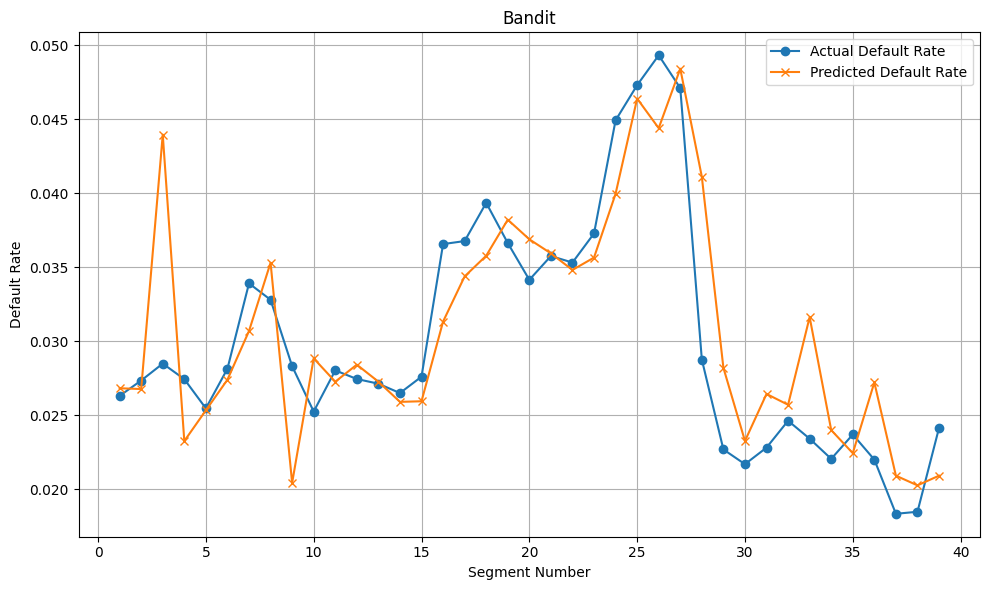

In [23]:
import matplotlib.pyplot as plt
bandit_eps_df = run_bandit_epsilon_greedy_n1(final_segments, threshold=0.03, epsilon=0.15)
df = bandit_eps_df.sort_values('segment_num')

plt.figure(figsize=(10, 6))
plt.plot(df['segment_num'], df['actual_default_rate'], label='Actual Default Rate', marker='o')
plt.plot(df['segment_num'], df['predicted_default_rate'], label='Predicted Default Rate', marker='x')
plt.xlabel('Segment Number')
plt.ylabel('Default Rate')
plt.title("Bandit")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [24]:
df

,segment,segment_num,type,auc,recall,specificity,actual_default_rate,predicted_default_rate,accept_rate,tn,fp,fn,tp
0,split_1,1,bandit_eps0.15_n1,0.649115,0.322398,0.835902,0.026322,0.026836,0.831735,27334,5366,599,285
1,split_2,2,bandit_eps0.15_n1,0.649952,0.366215,0.789894,0.027358,0.026782,0.785623,22775,6058,514,297
2,split_3,3,bandit_eps0.15_n1,0.623860,0.443276,0.724960,0.028502,0.043970,0.720165,32890,12478,741,590
3,split_4,4,bandit_eps0.15_n1,0.591231,0.355401,0.787314,0.027450,0.023271,0.783396,24017,6488,555,306
4,split_5,5,bandit_eps0.15_n1,0.622672,0.373522,0.782324,0.025477,0.025346,0.778353,25316,7044,530,316
5,split_6,6,bandit_eps0.15_n1,0.639603,0.434934,0.744864,0.028155,0.027414,0.739802,36946,12655,812,625
6,split_7,7,bandit_eps0.15_n1,0.641760,0.529231,0.668803,0.033920,0.030702,0.662086,18572,9197,459,516
7,split_8,8,bandit_eps0.15_n1,0.632986,0.632244,0.570172,0.032811,0.035314,0.563531,15950,12024,349,600
8,split_9,9,bandit_eps0.15_n1,0.598013,0.368060,0.765468,0.028327,0.020445,0.761685,42090,12896,1013,590
9,split_10,10,bandit_eps0.15_n1,0.648373,0.495719,0.707094,0.025261,0.028855,0.701970,31868,13201,589,579


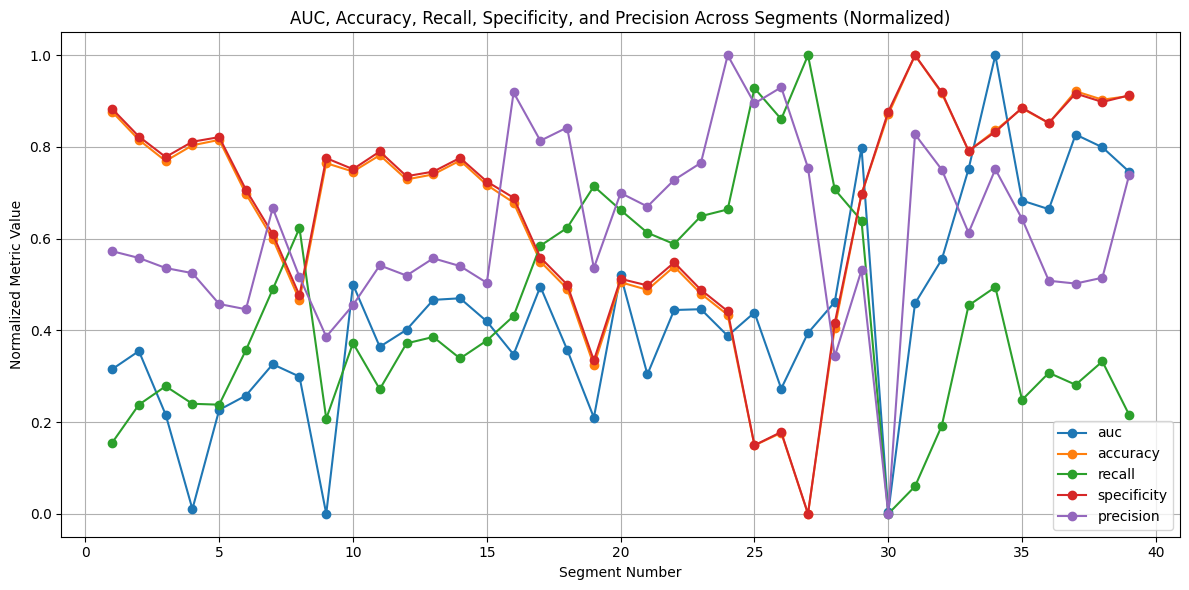

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Step 1: Sort and copy the DataFrame
df = bandit_eps_df.sort_values('segment_num').copy()

# Step 2: Compute additional metrics
df['accuracy'] = (df['tp'] + df['tn']) / (df['tp'] + df['tn'] + df['fp'] + df['fn'])
df['precision'] = df['tp'] / (df['tp'] + df['fp']).replace(0, np.nan)
df['precision'] = df['precision'].fillna(0)  # or keep NaN if you prefer

# Step 3: Select metrics to plot
metrics = ['auc', 'accuracy', 'recall', 'specificity', 'precision']

# Step 4: Normalize metrics for fair comparison
df_norm = df.copy()
df_norm[metrics] = df[metrics].apply(lambda x: (x - x.min()) / (x.max() - x.min()))

# Step 5: Plot
plt.figure(figsize=(12, 6))
for metric in metrics:
    plt.plot(df['segment_num'], df_norm[metric], marker='o', label=metric)

plt.xlabel('Segment Number')
plt.ylabel('Normalized Metric Value')
plt.title('AUC, Accuracy, Recall, Specificity, and Precision Across Segments (Normalized)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


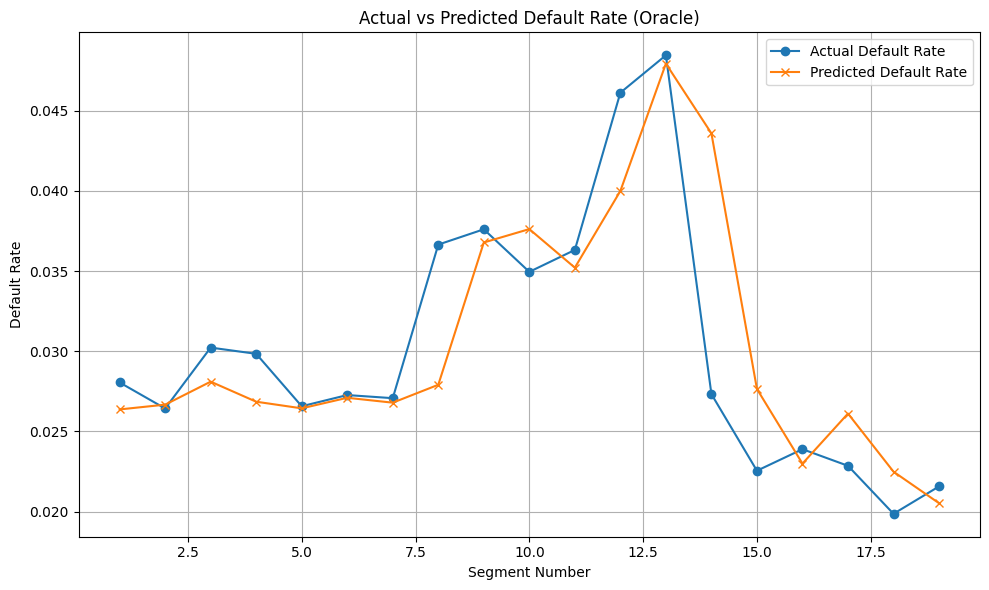

In [16]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, recall_score, confusion_matrix
import pandas as pd

results = []
exclude_cols = {'case_id', 'WEEK_NUM', 'target'}
features = [col for col in final_segments['split_0'].columns if col not in exclude_cols]

sorted_keys = sorted(final_segments.keys(), key=lambda x: int(x.split('_')[-1]))

for t in range(1, len(sorted_keys)):
    train_key = sorted_keys[t - 1]
    test_key = sorted_keys[t]

    # Prepare training and test data
    train_segment = final_segments[train_key]
    test_segment = final_segments[test_key]
    X_train_oracle = train_segment[features]
    y_train_oracle = train_segment["target"]
    X_test = test_segment[features]
    y_test = test_segment["target"]

    # Train Oracle model (full data)
    model_oracle = make_pipeline(StandardScaler(), LogisticRegression(max_iter=1000))
    model_oracle.fit(X_train_oracle, y_train_oracle)

    # Predict and evaluate
    y_pred_proba_oracle = model_oracle.predict_proba(X_test)[:, 1]
    y_pred_oracle = (y_pred_proba_oracle >= 0.03).astype(int)
    recall_oracle = recall_score(y_test, y_pred_oracle)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred_oracle).ravel()
    specificity_oracle = tn / (tn + fp)
    auc_oracle = roc_auc_score(y_test, y_pred_proba_oracle)
    accept_mask_oracle = y_pred_proba_oracle < 0.03

    results.append({
        "segment": test_key,
        "segment_num": int(test_key.split("_")[1]),
        "type": "oracle",
        "auc": auc_oracle,
        "recall": recall_oracle,
        "specificity": specificity_oracle,
        "actual_default_rate": y_test.mean(),
        "predicted_default_rate": y_pred_proba_oracle.mean(),
        "accept_rate": accept_mask_oracle.mean(),
        "tn": tn,
        "fp": fp,
        "fn": fn,
        "tp": tp
    })

results_df = pd.DataFrame(results)

import matplotlib.pyplot as plt

# Filter Oracle results
oracle_df = results_df[results_df['type'] == 'oracle'].sort_values('segment_num')

# Plot
plt.figure(figsize=(10, 6))
plt.plot(oracle_df['segment_num'], oracle_df['actual_default_rate'], label='Actual Default Rate', marker='o')
plt.plot(oracle_df['segment_num'], oracle_df['predicted_default_rate'], label='Predicted Default Rate', marker='x')
plt.xlabel('Segment Number')
plt.ylabel('Default Rate')
plt.title('Actual vs Predicted Default Rate (Oracle)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [18]:
def run_oracle_with_n_splits(final_segments, n_previous_splits=2, threshold=0.03):
    from sklearn.linear_model import LogisticRegression
    from sklearn.pipeline import make_pipeline
    from sklearn.preprocessing import StandardScaler
    from sklearn.metrics import roc_auc_score, recall_score, confusion_matrix
    import pandas as pd

    results = []
    exclude_cols = {'case_id', 'WEEK_NUM', 'target'}
    features = [col for col in final_segments['split_0'].columns if col not in exclude_cols]
    sorted_keys = sorted(final_segments.keys(), key=lambda x: int(x.split('_')[-1]))

    for t in range(n_previous_splits, len(sorted_keys)):
        train_keys = sorted_keys[t - n_previous_splits:t]
        test_key = sorted_keys[t]

        # Combine training data from the previous n splits
        X_train_list = []
        y_train_list = []
        for key in train_keys:
            segment = final_segments[key]
            X_train_list.append(segment[features])
            y_train_list.append(segment["target"])

        X_train_oracle = pd.concat(X_train_list, ignore_index=True)
        y_train_oracle = pd.concat(y_train_list, ignore_index=True)

        # Prepare test data
        test_segment = final_segments[test_key]
        X_test = test_segment[features]
        y_test = test_segment["target"]

        # Train model
        model = make_pipeline(StandardScaler(), LogisticRegression(max_iter=1000))
        model.fit(X_train_oracle, y_train_oracle)

        # Predict and evaluate
        y_pred_proba = model.predict_proba(X_test)[:, 1]
        y_pred = (y_pred_proba >= threshold).astype(int)
        recall = recall_score(y_test, y_pred)
        tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
        specificity = tn / (tn + fp)
        auc = roc_auc_score(y_test, y_pred_proba)
        accept_mask = y_pred_proba < threshold

        results.append({
            "segment": test_key,
            "segment_num": int(test_key.split("_")[1]),
            "type": f"oracle_{n_previous_splits}splits",
            "auc": auc,
            "recall": recall,
            "specificity": specificity,
            "actual_default_rate": y_test.mean(),
            "predicted_default_rate": y_pred_proba.mean(),
            "accept_rate": accept_mask.mean(),
            "tn": tn,
            "fp": fp,
            "fn": fn,
            "tp": tp
        })

    return pd.DataFrame(results)



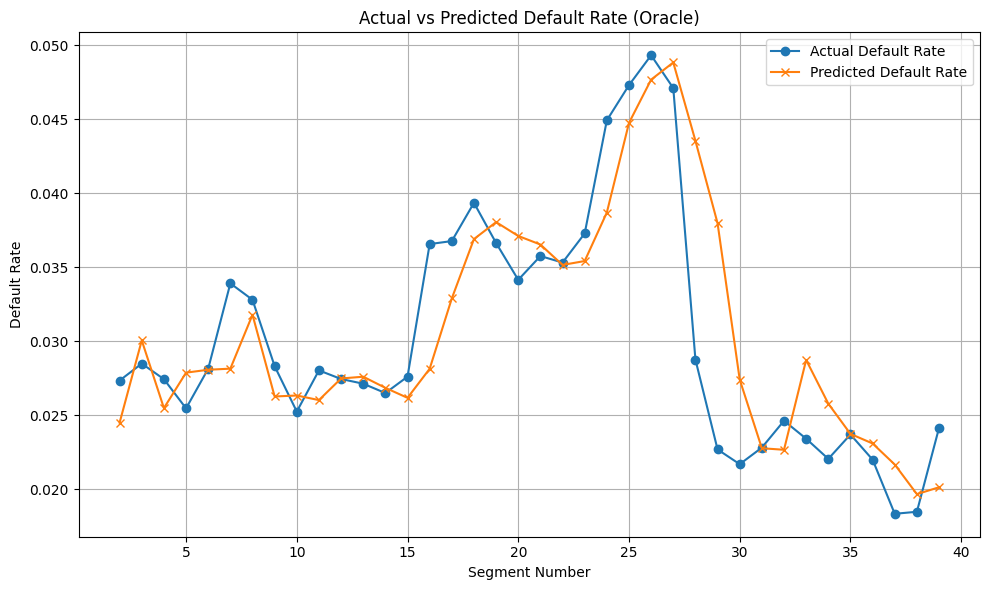

In [23]:
oracle_df = run_oracle_with_n_splits(final_segments, n_previous_splits=2)
oracle_df = oracle_df.sort_values('segment_num')
plt.figure(figsize=(10, 6))
plt.plot(oracle_df['segment_num'], oracle_df['actual_default_rate'], label='Actual Default Rate', marker='o')
plt.plot(oracle_df['segment_num'], oracle_df['predicted_default_rate'], label='Predicted Default Rate', marker='x')
plt.xlabel('Segment Number')
plt.ylabel('Default Rate')
plt.title('Actual vs Predicted Default Rate (Oracle)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


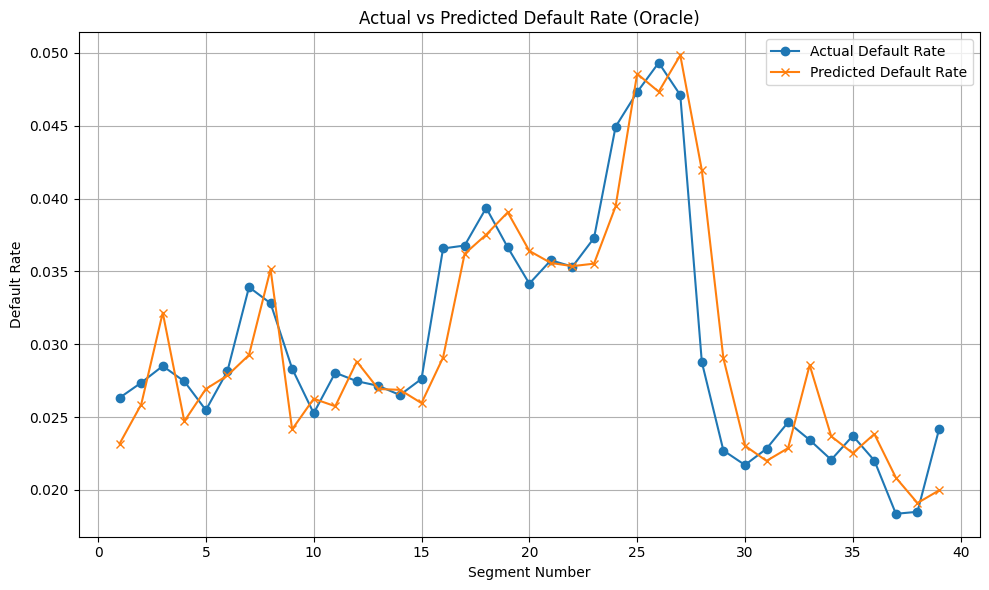

In [21]:
oracle_df = run_oracle_with_n_splits(final_segments, n_previous_splits=1)
oracle_df = oracle_df.sort_values('segment_num')
plt.figure(figsize=(10, 6))
plt.plot(oracle_df['segment_num'], oracle_df['actual_default_rate'], label='Actual Default Rate', marker='o')
plt.plot(oracle_df['segment_num'], oracle_df['predicted_default_rate'], label='Predicted Default Rate', marker='x')
plt.xlabel('Segment Number')
plt.ylabel('Default Rate')
plt.title('Actual vs Predicted Default Rate (Oracle)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [24]:
def run_bandit_n1(final_segments, threshold=0.03):

    from sklearn.linear_model import LogisticRegression
    from sklearn.pipeline import make_pipeline
    from sklearn.preprocessing import StandardScaler
    from sklearn.metrics import roc_auc_score, recall_score, confusion_matrix
    import pandas as pd

    results = []
    exclude_cols = {'case_id', 'WEEK_NUM', 'target'}
    features = [col for col in final_segments['split_0'].columns if col not in exclude_cols]
    sorted_keys = sorted(final_segments.keys(), key=lambda x: int(x.split('_')[-1]))

    # Initialize training data using split_0
    X_train = final_segments[sorted_keys[0]][features]
    y_train = final_segments[sorted_keys[0]]['target']

    for t in range(1, len(sorted_keys)):
        test_key = sorted_keys[t]
        test_segment = final_segments[test_key]
        X_test = test_segment[features]
        y_test = test_segment['target']

        # Train model on approved applicants so far
        model = make_pipeline(StandardScaler(), LogisticRegression(max_iter=1000))
        model.fit(X_train, y_train)

        # Predict and evaluate
        y_pred_proba = model.predict_proba(X_test)[:, 1]
        y_pred = (y_pred_proba >= threshold).astype(int)
        recall = recall_score(y_test, y_pred)
        tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
        specificity = tn / (tn + fp)
        auc = roc_auc_score(y_test, y_pred_proba)
        accept_mask = y_pred_proba < threshold  # applicants predicted below threshold are approved

        results.append({
            "segment": test_key,
            "segment_num": int(test_key.split("_")[1]),
            "type": "bandit_n1",
            "auc": auc,
            "recall": recall,
            "specificity": specificity,
            "actual_default_rate": y_test.mean(),
            "predicted_default_rate": y_pred_proba.mean(),
            "accept_rate": accept_mask.mean(),
            "tn": tn,
            "fp": fp,
            "fn": fn,
            "tp": tp
        })

        # Add only approved applicants to training set
        X_train = pd.concat([X_train, X_test[accept_mask]], ignore_index=True)
        y_train = pd.concat([y_train, y_test[accept_mask]], ignore_index=True)

    return pd.DataFrame(results)


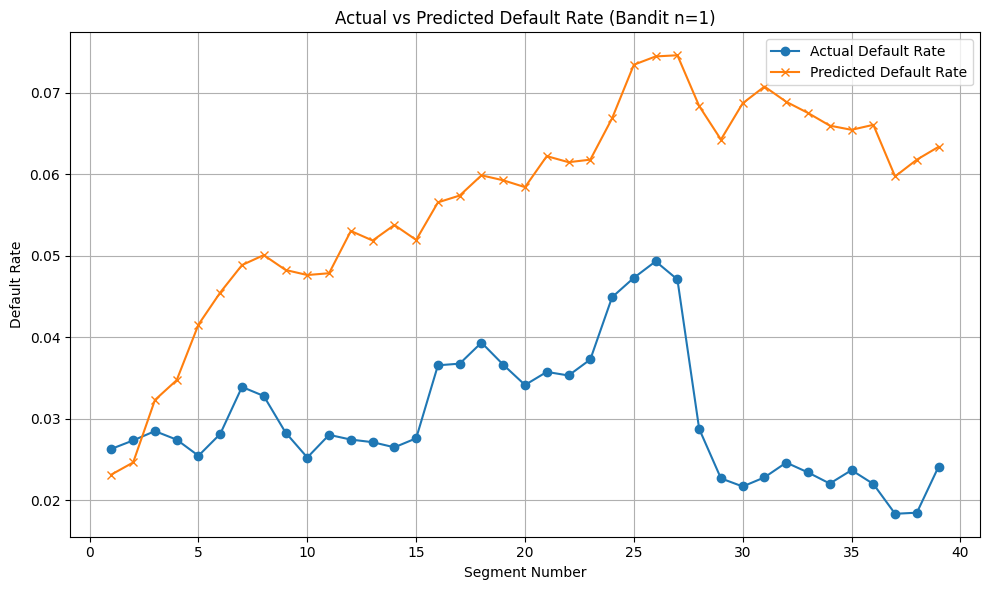

In [25]:
bandit_df = run_bandit_n1(final_segments, threshold=0.03)
bandit_df = bandit_df.sort_values("segment_num")

# Plot
plt.figure(figsize=(10, 6))
plt.plot(bandit_df['segment_num'], bandit_df['actual_default_rate'], label='Actual Default Rate', marker='o')
plt.plot(bandit_df['segment_num'], bandit_df['predicted_default_rate'], label='Predicted Default Rate', marker='x')
plt.xlabel('Segment Number')
plt.ylabel('Default Rate')
plt.title('Actual vs Predicted Default Rate (Bandit n=1)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
def approval_utility(y_true, y_pred_proba, threshold,
                     reward_approve_good, penalty_approve_bad):
    approve = y_pred_proba < threshold
    approve_good = ((approve == 1) & (y_true == 0)).sum()
    approve_bad = ((approve == 1) & (y_true == 1)).sum()

    return reward_approve_good * approve_good + penalty_approve_bad * approve_bad

def find_best_threshold(y_true, y_pred_proba, utility_func, **kwargs):
    thresholds = np.linspace(0.01, 0.99, 99)  
    best_threshold = 0.5
    best_utility = -np.inf

    for t in thresholds:
        u = utility_func(y_true, y_pred_proba, threshold=t, **kwargs)
        if u > best_utility:
            best_utility = u
            best_threshold = t

    return best_threshold, best_utility



In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score
from sklearn.metrics import recall_score, confusion_matrix

results = []
exclude_cols = {'case_id', 'WEEK_NUM', 'target'}
features = [col for col in final_segments['split_0'].columns if col not in exclude_cols]
X_train_bandit = final_segments['split_0'][features]
y_train_bandit = final_segments['split_0']['target']

X_train_oracle = X_train_bandit.copy()
y_train_oracle = y_train_bandit.copy()

sorted_keys = sorted(final_segments.keys(), key=lambda x: int(x.split('_')[-1]))
for t in range(1, len(sorted_keys)):
    split_key = sorted_keys[t]
    test_segment = final_segments[split_key]
    X_test = test_segment[features]
    y_test = test_segment["target"]

    # BANDIT MODEL (only approved applicants) 
    model_bandit = make_pipeline(StandardScaler(), LogisticRegression(max_iter=1000))
    model_bandit.fit(X_train_bandit, y_train_bandit)

    y_pred_proba_bandit = model_bandit.predict_proba(X_test)[:, 1]
    auc_bandit = roc_auc_score(y_test, y_pred_proba_bandit)

    thresh_bandit = 0.03
    accept_mask_bandit = y_pred_proba_bandit < thresh_bandit
    y_pred_bandit = (y_pred_proba_bandit>=thresh_bandit).astype(int)
    recall_bandit = recall_score(y_test, y_pred_bandit)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred_bandit).ravel()
    specificity_bandit = tn / (tn + fp)


    results.append({
        "segment": split_key,
        "segment_num": int(split_key.split("_")[1]),
        "type": "bandit",
        "auc": auc_bandit,
        "recall": recall_bandit,
        "specificity": specificity_bandit,
        "actual_default_rate": y_test.mean(),
        "predicted_default_rate": y_pred_proba_bandit.mean(),
        "accept_rate": accept_mask_bandit.mean(),
         "tn": tn,
        "fp": fp,
        "fn": fn,
        "tp": tp
})

    # Update bandit training data (only approved)
    X_train_bandit = pd.concat([X_train_bandit, X_test[accept_mask_bandit]], ignore_index=True)
    y_train_bandit = pd.concat([y_train_bandit, y_test[accept_mask_bandit]], ignore_index=True)

    # ORACLE MODEL (sees full data)
    model_oracle = make_pipeline(StandardScaler(), LogisticRegression(max_iter=1000))
    model_oracle.fit(X_train_oracle, y_train_oracle)

    y_pred_proba_oracle = model_oracle.predict_proba(X_test)[:, 1]
    auc_oracle = roc_auc_score(y_test, y_pred_proba_oracle)


    thresh_oracle = 0.03
    accept_mask_oracle = y_pred_proba_oracle < thresh_oracle
    y_pred_oracle = (y_pred_proba_oracle>=thresh_oracle).astype(int)
    recall_oracle = recall_score(y_test, y_pred_oracle)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred_oracle).ravel()
    specificity_oracle = tn / (tn + fp)
    results.append({
        "segment": split_key,
        "segment_num": int(split_key.split("_")[1]),
        "type": "oracle",
        "auc": auc_oracle,
        "recall": recall_oracle,
        "specificity": specificity_oracle,
        "actual_default_rate": y_test.mean(),
        "predicted_default_rate": y_pred_proba_oracle.mean(),
        "accept_rate": accept_mask_oracle.mean(),
         "tn": tn,
        "fp": fp,
        "fn": fn,
        "tp": tp
})

    # Oracle adds all test applicants to training
    X_train_oracle = pd.concat([X_train_oracle, X_test], ignore_index=True)
    y_train_oracle = pd.concat([y_train_oracle, y_test], ignore_index=True)

results_df = pd.DataFrame(results)


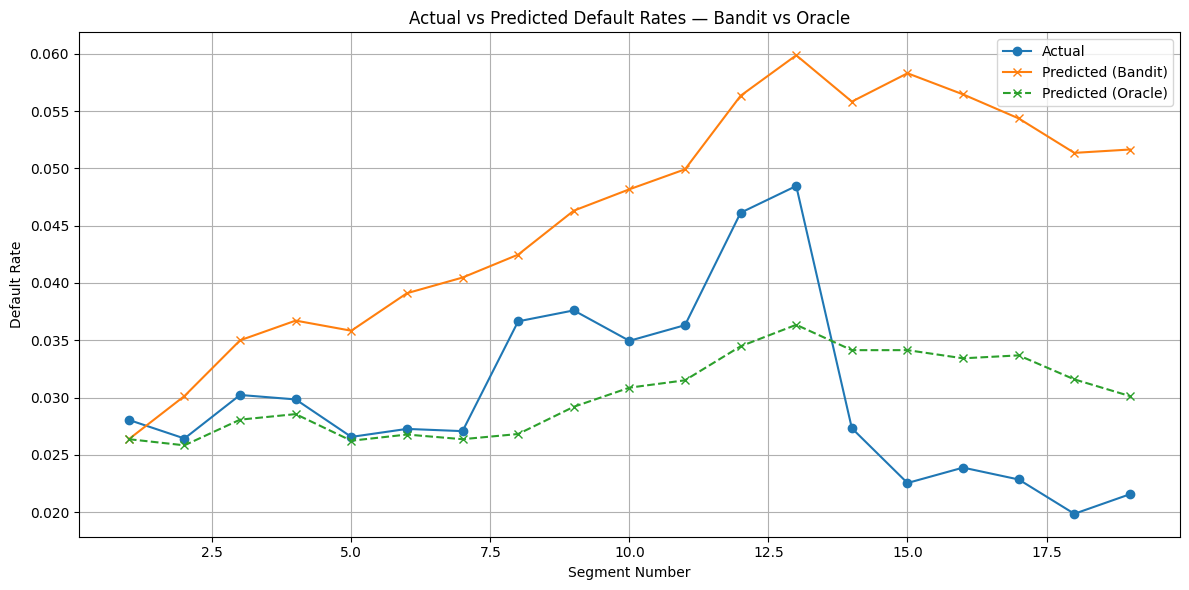

In [ ]:
import matplotlib.pyplot as plt

df_bandit = results_df[results_df["type"] == "bandit"].sort_values("segment_num")
df_oracle = results_df[results_df["type"] == "oracle"].sort_values("segment_num")
plt.figure(figsize=(12, 6))

# Bandit
plt.plot(df_bandit["segment_num"], df_bandit["actual_default_rate"], label="Actual", marker='o')
plt.plot(df_bandit["segment_num"], df_bandit["predicted_default_rate"], label="Predicted (Bandit)", marker='x')

# Oracle
plt.plot(df_oracle["segment_num"], df_oracle["predicted_default_rate"], label="Predicted (Oracle)", marker='x', linestyle='--')

plt.xlabel("Segment Number")
plt.ylabel("Default Rate")
plt.title("Actual vs Predicted Default Rates — Bandit vs Oracle")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('../Figures/plot2.pdf', format='pdf')
plt.show()


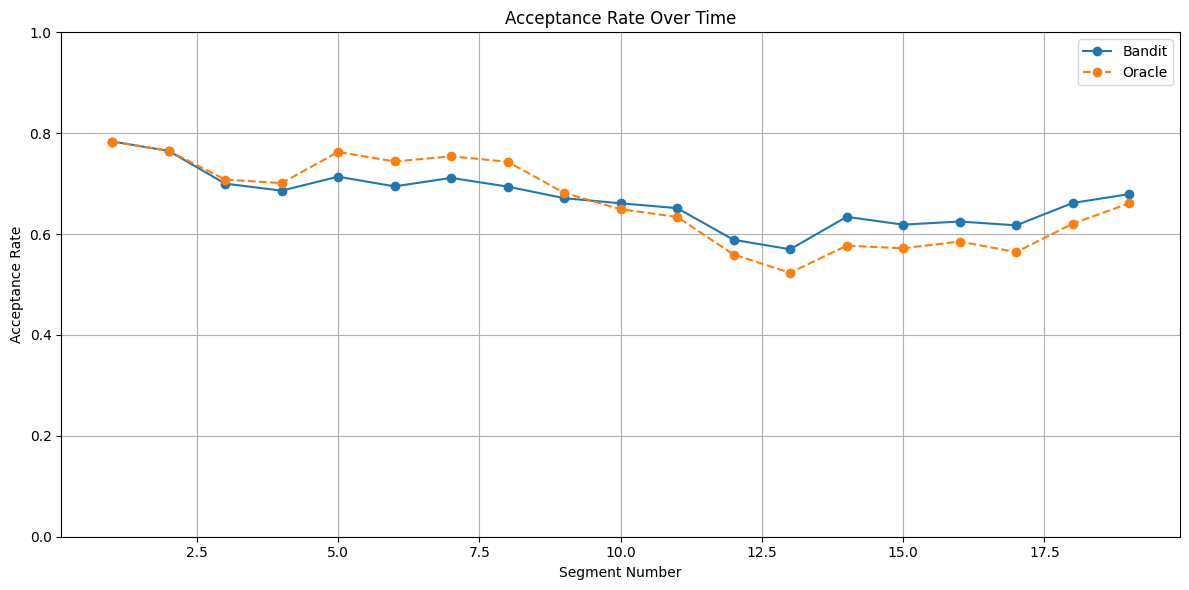

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(df_bandit["segment_num"], df_bandit["accept_rate"], label="Bandit", marker='o')
plt.plot(df_oracle["segment_num"], df_oracle["accept_rate"], label="Oracle", marker='o', linestyle='--')

plt.title("Acceptance Rate Over Time")
plt.xlabel("Segment Number")
plt.ylabel("Acceptance Rate")
plt.ylim(0, 1)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

## Recall = $\frac{TP}{TP + FN}$ , Specificity = $\frac{TN}{TN + FP}$ 

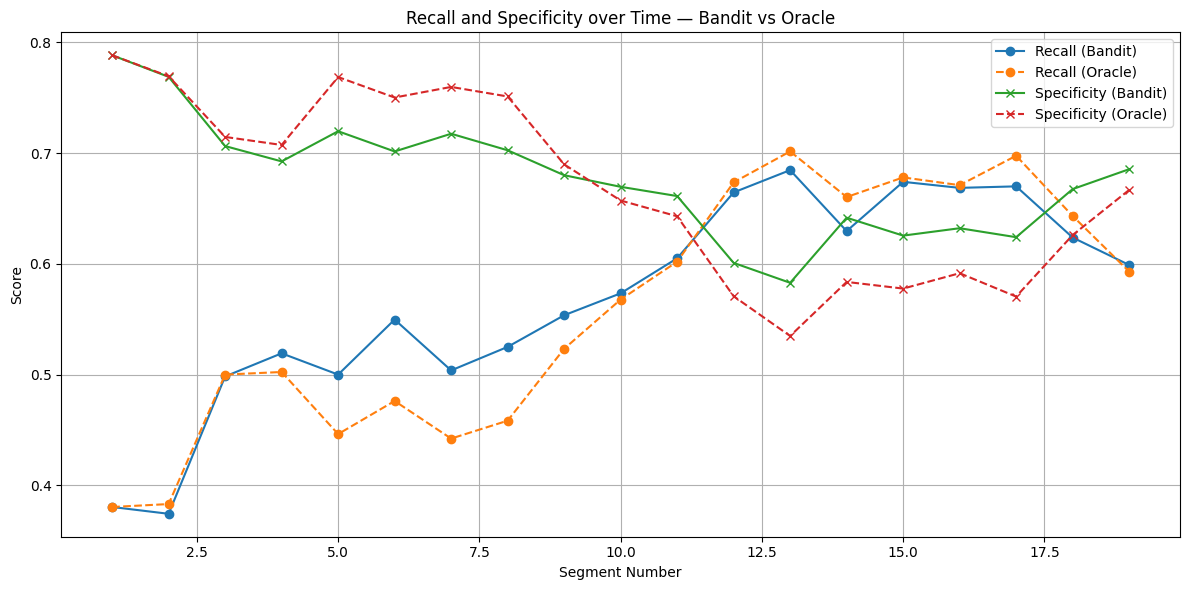

In [ ]:
plt.figure(figsize=(12, 6))

plt.plot(df_bandit["segment_num"], df_bandit["recall"], label="Recall (Bandit)", marker='o')
plt.plot(df_oracle["segment_num"], df_oracle["recall"], label="Recall (Oracle)", marker='o', linestyle='--')
plt.plot(df_bandit["segment_num"], df_bandit["specificity"], label="Specificity (Bandit)", marker='x')
plt.plot(df_oracle["segment_num"], df_oracle["specificity"], label="Specificity (Oracle)", marker='x', linestyle='--')
plt.xlabel("Segment Number")
plt.ylabel("Score")
plt.title("Recall and Specificity over Time — Bandit vs Oracle")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('../Figures/plot3.pdf', format='pdf')
plt.show()

# FN = Incorrectly accepted a defaulter, FP = Incorrectly rejected a non-defaulter
# TN = Accepted correctly, TP = Rejected correctly

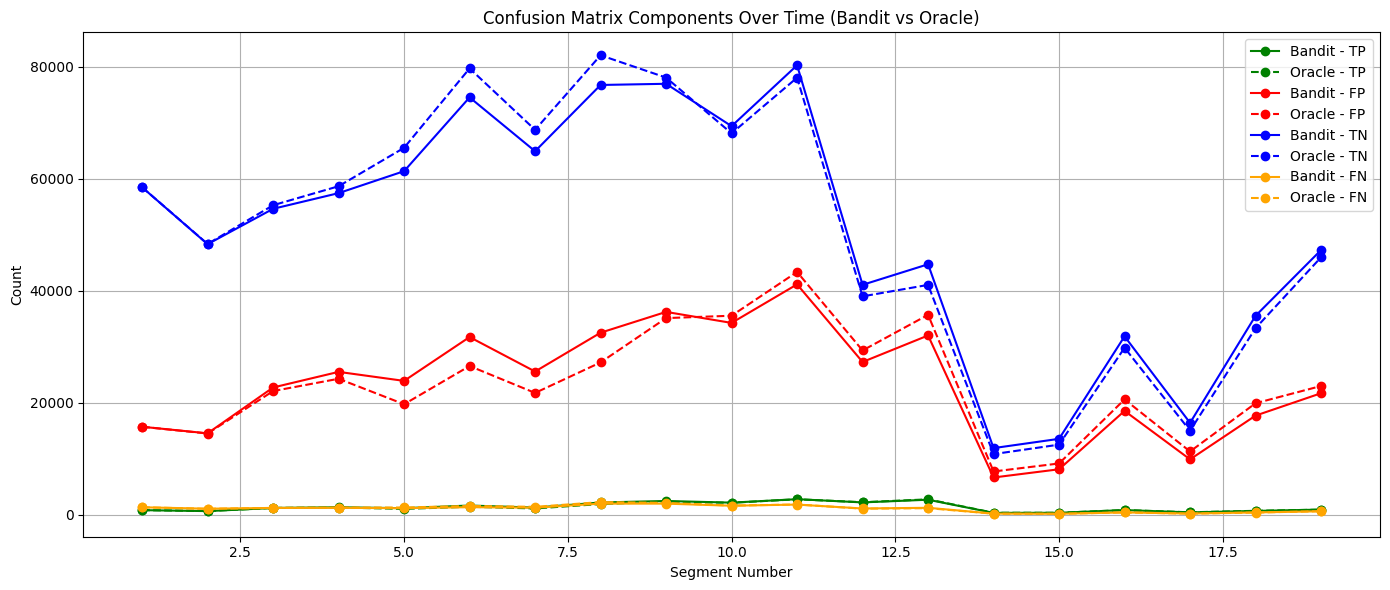

In [ ]:
plt.figure(figsize=(14, 6))
metrics = ["tp", "fp", "tn", "fn"]
colors = ["green", "red", "blue", "orange"]
styles = {"bandit": "-", "oracle": "--"}

for metric, color in zip(metrics, colors):
    for model_type in ["bandit", "oracle"]:
        df = results_df[results_df["type"] == model_type]
        label = f"{model_type.capitalize()} - {metric.upper()}"
        plt.plot(
            df["segment_num"],
            df[metric],
            linestyle=styles[model_type],
            color=color,
            marker='o',
            label=label
        )

plt.title("Confusion Matrix Components Over Time (Bandit vs Oracle)")
plt.xlabel("Segment Number")
plt.ylabel("Count")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
results_df

,segment,segment_num,type,auc,recall,specificity,actual_default_rate,predicted_default_rate,accept_rate
0,split_1,1,bandit,0.632584,0.380486,0.788264,0.028058,0.026376,0.783530
1,split_1,1,oracle,0.632584,0.380486,0.788264,0.028058,0.026376,0.783530
2,split_2,2,bandit,0.610811,0.374341,0.768774,0.026436,0.030140,0.764991
3,split_2,2,oracle,0.623296,0.383128,0.769299,0.026436,0.025840,0.765270
4,split_3,3,bandit,0.650528,0.498342,0.706282,0.030232,0.035000,0.700095
5,split_3,3,oracle,0.648555,0.500000,0.714541,0.030232,0.028080,0.708054
6,split_4,4,bandit,0.653941,0.519201,0.692454,0.029844,0.036719,0.686138
7,split_4,4,oracle,0.648705,0.502351,0.707281,0.029844,0.028564,0.701024
8,split_5,5,bandit,0.666443,0.500000,0.719680,0.026575,0.035836,0.713842
9,split_5,5,oracle,0.661131,0.446306,0.768593,0.026575,0.026242,0.762882


Threshold not used: 0.9300
Predicted defaulters: 40802
Predicted non-defaulters: 35541
Max predicted probability: 0.9710
Threshold used: 0.0200
Threshold not used: 0.9500
Predicted defaulters: 36013
Predicted non-defaulters: 28559
Max predicted probability: 0.6811
Threshold used: 0.0200
Threshold not used: 0.9600
Predicted defaulters: 55119
Predicted non-defaulters: 24663
Max predicted probability: 0.8181
Threshold used: 0.0200
Threshold not used: 0.9800
Predicted defaulters: 57384
Predicted non-defaulters: 28128
Max predicted probability: 0.9274
Threshold used: 0.0200
Threshold not used: 0.9700
Predicted defaulters: 48027
Predicted non-defaulters: 39575
Max predicted probability: 1.0000
Threshold used: 0.0200
Threshold not used: 0.9900
Predicted defaulters: 62822
Predicted non-defaulters: 46445
Max predicted probability: 1.0000
Threshold used: 0.0200
Threshold not used: 0.9900
Predicted defaulters: 52443
Predicted non-defaulters: 40585
Max predicted probability: 0.7958
Threshold used:

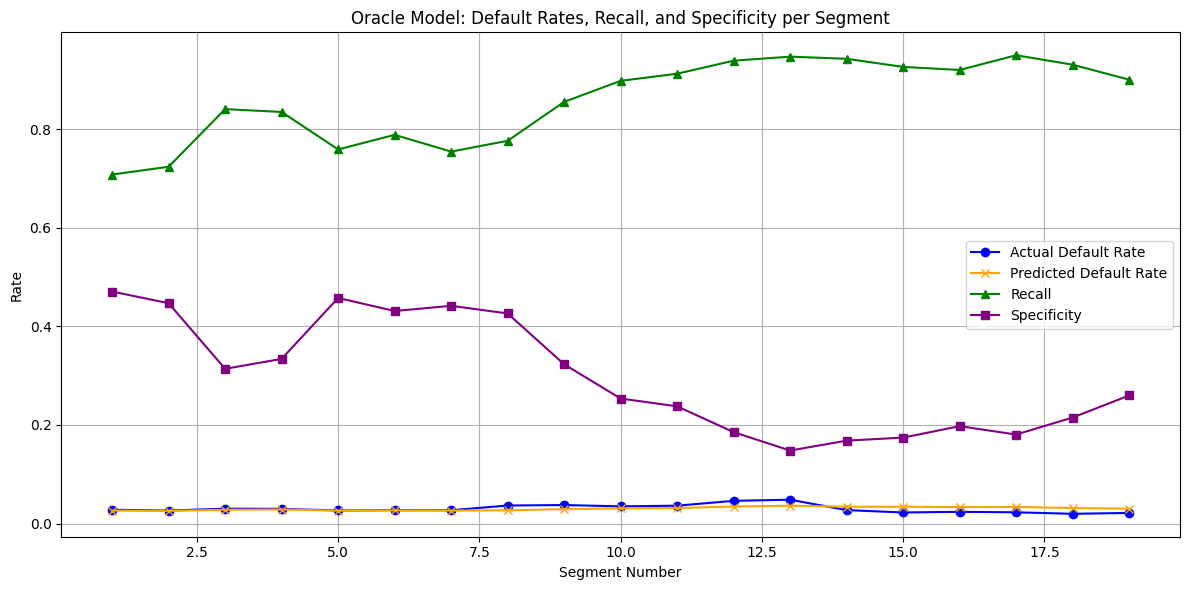

In [ ]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, confusion_matrix
import matplotlib.pyplot as plt

# --- Helper functions ---

def compute_recall_specificity(y_true, y_pred_label):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred_label).ravel()
    recall = tp / (tp + fn) if (tp + fn) > 0 else float('nan')
    specificity = tn / (tn + fp) if (tn + fp) > 0 else float('nan')
    return recall, specificity

def find_best_threshold(y_true, y_pred_proba):
    thresholds = np.linspace(0.01, 0.99, 99)
    best_threshold = 0.5
    best_utility = -np.inf
    for t in thresholds:
        approve = y_pred_proba < t
        approve_good = ((approve == 1) & (y_true == 0)).sum()
        approve_bad = ((approve == 1) & (y_true == 1)).sum()
        reject_good = ((approve == 0) & (y_true == 0)).sum()
        utility = 1 * approve_good + (-20000) * approve_bad -10000*reject_good
        if utility > best_utility:
            best_utility = utility
            best_threshold = t
    return best_threshold

# --- Setup ---

exclude_cols = {'case_id', 'WEEK_NUM', 'target'}
sorted_keys = sorted(final_segments.keys(), key=lambda x: int(x.split('_')[1]))
features = [col for col in final_segments['split_0'].columns if col not in exclude_cols]

# Initialize tracking lists
segment_nums, recalls, specificities, actual_rates, predicted_rates = [], [], [], [], []

# Start with initial training data
X_train = final_segments['split_0'][features]
y_train = final_segments['split_0']['target']

# Loop through test splits
for t in range(1, len(sorted_keys)):
    split_key = sorted_keys[t]
    test_segment = final_segments[split_key]
    X_test = test_segment[features]
    y_test = test_segment["target"]

    # Train oracle model on all available data
    model = make_pipeline(StandardScaler(), LogisticRegression(max_iter=1000))
    model.fit(X_train, y_train)

    y_pred_proba = model.predict_proba(X_test)[:, 1]
    predicted_rate = y_pred_proba.mean()
    actual_rate = y_test.mean()

    # Find best threshold using training data
    y_pred_proba_train = model.predict_proba(X_train)[:, 1]
    best_thresh = find_best_threshold(y_train, y_pred_proba_train)
    print(f"Threshold not used: {best_thresh:.4f}")
    best_thresh = min(best_thresh, 0.02)
    # Compute recall and specificity at best threshold
    y_pred_label = (y_pred_proba >= best_thresh).astype(int)

    num_defaulters = y_pred_label.sum()
    num_non_defaulters = (y_pred_label == 0).sum()

    print(f"Predicted defaulters: {num_defaulters}")
    print(f"Predicted non-defaulters: {num_non_defaulters}")

    print(f"Max predicted probability: {y_pred_proba.max():.4f}")
    print(f"Threshold used: {best_thresh:.4f}")


    recall, specificity = compute_recall_specificity(y_test, y_pred_label)

    # Track results
    segment_nums.append(t)
    recalls.append(recall)
    specificities.append(specificity)
    actual_rates.append(actual_rate)
    predicted_rates.append(predicted_rate)

    # Oracle sees all of current test segment
    X_train = pd.concat([X_train, X_test], ignore_index=True)
    y_train = pd.concat([y_train, y_test], ignore_index=True)

# --- Plot all metrics ---

plt.figure(figsize=(12, 6))

plt.plot(segment_nums, actual_rates, marker='o', label="Actual Default Rate", color='blue')
plt.plot(segment_nums, predicted_rates, marker='x', label="Predicted Default Rate", color='orange')
plt.plot(segment_nums, recalls, marker='^', label="Recall", color='green')
plt.plot(segment_nums, specificities, marker='s', label="Specificity", color='purple')

plt.xlabel("Segment Number")
plt.ylabel("Rate")
plt.title("Oracle Model: Default Rates, Recall, and Specificity per Segment")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


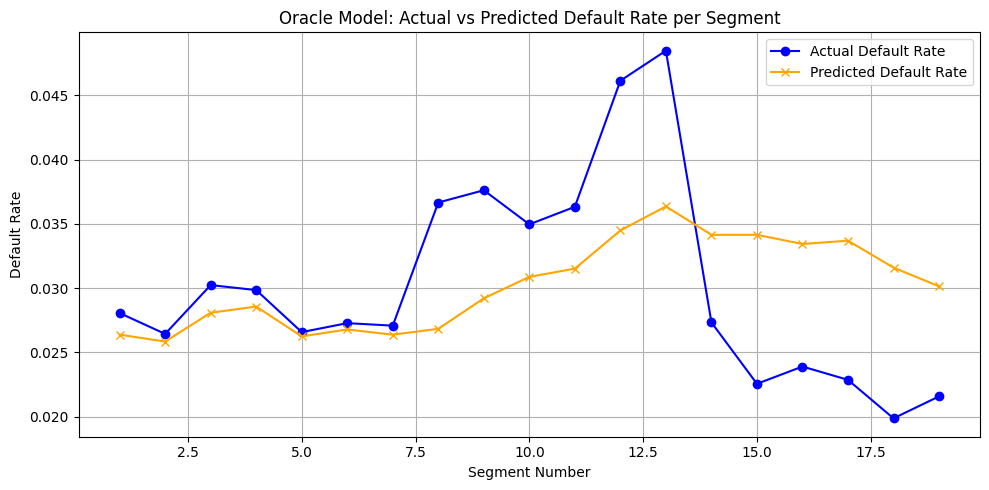

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))

plt.plot(segment_nums, actual_rates, marker='o', label="Actual Default Rate", color='blue')
plt.plot(segment_nums, predicted_rates, marker='x', label="Predicted Default Rate", color='orange')

plt.xlabel("Segment Number")
plt.ylabel("Default Rate")
plt.title("Oracle Model: Actual vs Predicted Default Rate per Segment")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import roc_auc_score, recall_score, confusion_matrix
import pandas as pd

results = []
exclude_cols = {'case_id', 'WEEK_NUM', 'target'}
features = [col for col in final_segments['split_0'].columns if col not in exclude_cols]

X_train_bandit = final_segments['split_0'][features]
y_train_bandit = final_segments['split_0']['target']

X_train_oracle = X_train_bandit.copy()
y_train_oracle = y_train_bandit.copy()

# Define the SGD model (online logistic regression)
model_bandit = make_pipeline(
    StandardScaler(),
    SGDClassifier(loss='log_loss', max_iter=1, warm_start=True, learning_rate='optimal', tol=None)
)
model_oracle = make_pipeline(
    StandardScaler(),
    SGDClassifier(loss='log_loss', max_iter=1, warm_start=True, learning_rate='optimal', tol=None)
)

# Initial fit (important for setting up internal parameters)
model_bandit.fit(X_train_bandit, y_train_bandit)
model_oracle.fit(X_train_oracle, y_train_oracle)

sorted_keys = sorted(final_segments.keys(), key=lambda x: int(x.split('_')[-1]))

for t in range(1, len(sorted_keys)):
    split_key = sorted_keys[t]
    test_segment = final_segments[split_key]
    X_test = test_segment[features]
    y_test = test_segment["target"]

    # BANDIT
    y_pred_proba_bandit = model_bandit.predict_proba(X_test)[:, 1]
    auc_bandit = roc_auc_score(y_test, y_pred_proba_bandit)
    y_pred_bandit = (y_pred_proba_bandit >= 0.03).astype(int)
    accept_mask_bandit = y_pred_proba_bandit < 0.03
    recall_bandit = recall_score(y_test, y_pred_bandit)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred_bandit).ravel()
    specificity_bandit = tn / (tn + fp)

    results.append({
        "segment": split_key,
        "segment_num": int(split_key.split("_")[1]),
        "type": "bandit",
        "auc": auc_bandit,
        "recall": recall_bandit,
        "specificity": specificity_bandit,
        "actual_default_rate": y_test.mean(),
        "predicted_default_rate": y_pred_proba_bandit.mean(),
        "accept_rate": accept_mask_bandit.mean()
    })

    # Update bandit with only accepted applicants
    if accept_mask_bandit.any():
        model_bandit.named_steps['sgdclassifier'].partial_fit(
            StandardScaler().fit_transform(X_test[accept_mask_bandit]), 
            y_test[accept_mask_bandit], 
            classes=[0, 1]
        )

    # ORACLE
    y_pred_proba_oracle = model_oracle.predict_proba(X_test)[:, 1]
    auc_oracle = roc_auc_score(y_test, y_pred_proba_oracle)
    y_pred_oracle = (y_pred_proba_oracle >= 0.03).astype(int)
    accept_mask_oracle = y_pred_proba_oracle < 0.03
    recall_oracle = recall_score(y_test, y_pred_oracle)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred_oracle).ravel()
    specificity_oracle = tn / (tn + fp)

    results.append({
        "segment": split_key,
        "segment_num": int(split_key.split("_")[1]),
        "type": "oracle",
        "auc": auc_oracle,
        "recall": recall_oracle,
        "specificity": specificity_oracle,
        "actual_default_rate": y_test.mean(),
        "predicted_default_rate": y_pred_proba_oracle.mean(),
        "accept_rate": accept_mask_oracle.mean()
    })

    # Update oracle with full test data
    model_oracle.named_steps['sgdclassifier'].partial_fit(
        StandardScaler().fit_transform(X_test),
        y_test,
        classes=[0, 1]
    )

results_df = pd.DataFrame(results)


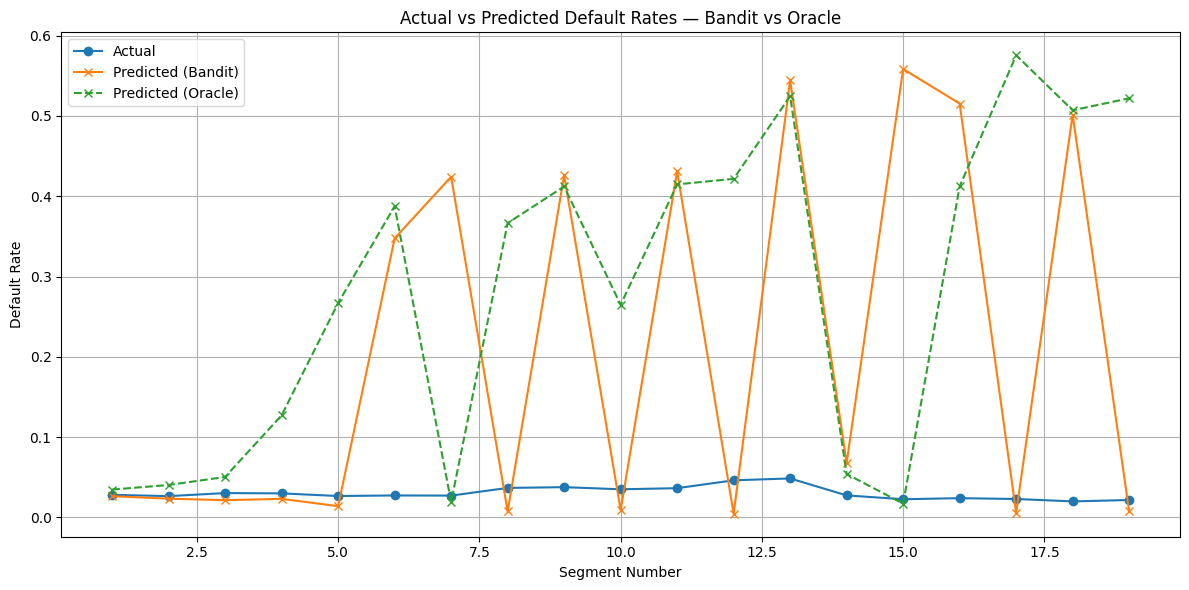

In [ ]:
import matplotlib.pyplot as plt

df_bandit = results_df[results_df["type"] == "bandit"].sort_values("segment_num")
df_oracle = results_df[results_df["type"] == "oracle"].sort_values("segment_num")
plt.figure(figsize=(12, 6))

# Bandit
plt.plot(df_bandit["segment_num"], df_bandit["actual_default_rate"], label="Actual", marker='o')
plt.plot(df_bandit["segment_num"], df_bandit["predicted_default_rate"], label="Predicted (Bandit)", marker='x')

# Oracle
plt.plot(df_oracle["segment_num"], df_oracle["predicted_default_rate"], label="Predicted (Oracle)", marker='x', linestyle='--')

plt.xlabel("Segment Number")
plt.ylabel("Default Rate")
plt.title("Actual vs Predicted Default Rates — Bandit vs Oracle")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('../Figures/plot4.pdf', format='pdf')
plt.show()

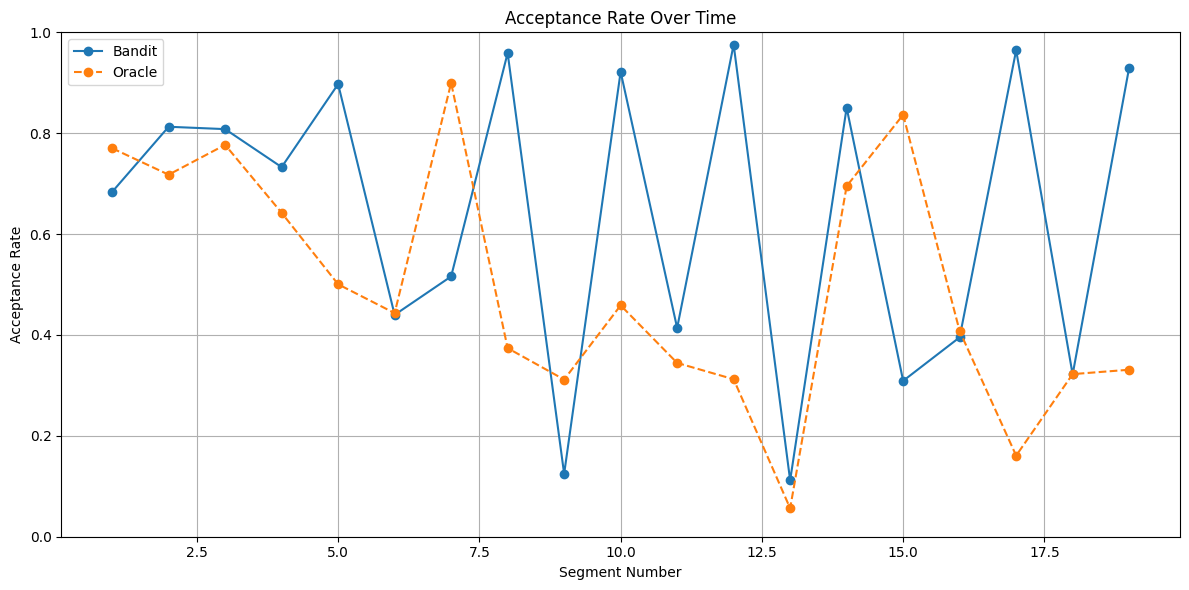

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(df_bandit["segment_num"], df_bandit["accept_rate"], label="Bandit", marker='o')
plt.plot(df_oracle["segment_num"], df_oracle["accept_rate"], label="Oracle", marker='o', linestyle='--')

plt.title("Acceptance Rate Over Time")
plt.xlabel("Segment Number")
plt.ylabel("Acceptance Rate")
plt.ylim(0, 1)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
results_df

,segment,segment_num,type,auc,recall,specificity,actual_default_rate,predicted_default_rate,accept_rate
0,split_1,1,bandit,0.490278,0.315126,0.683549,0.028058,0.026308,0.683586
1,split_1,1,oracle,0.557704,0.315593,0.772698,0.028058,0.034622,0.770221
2,split_2,2,bandit,0.544128,0.281781,0.815366,0.026436,0.023265,0.812798
3,split_2,2,oracle,0.578368,0.400703,0.720974,0.026436,0.040289,0.717757
4,split_3,3,bandit,0.542545,0.262023,0.810288,0.030232,0.021375,0.808102
5,split_3,3,oracle,0.566859,0.342040,0.780626,0.030232,0.050310,0.776917
6,split_4,4,bandit,0.487967,0.290752,0.733474,0.029844,0.023013,0.732751
7,split_4,4,oracle,0.636290,0.542712,0.647842,0.029844,0.127132,0.642155
8,split_5,5,bandit,0.436214,0.153351,0.898726,0.026575,0.013943,0.897343
9,split_5,5,oracle,0.675697,0.752148,0.507353,0.026575,0.266930,0.500457


In [ ]:
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, recall_score, confusion_matrix
import pandas as pd

results = []

exclude_cols = {'case_id', 'WEEK_NUM', 'target'}
features = [col for col in final_segments['split_0'].columns if col not in exclude_cols]

X_train_bandit = final_segments['split_0'][features]
y_train_bandit = final_segments['split_0']['target']

X_train_oracle = X_train_bandit.copy()
y_train_oracle = y_train_bandit.copy()

# Define scalers and classifiers
scaler_bandit = StandardScaler()
scaler_oracle = StandardScaler()

clf_bandit = SGDClassifier(loss='log_loss', max_iter=1, warm_start=True, learning_rate='optimal', tol=None)
clf_oracle = SGDClassifier(loss='log_loss', max_iter=1, warm_start=True, learning_rate='optimal', tol=None)

# Initial fit (scaler + classifier)
X_bandit_scaled = scaler_bandit.fit_transform(X_train_bandit)
X_oracle_scaled = scaler_oracle.fit_transform(X_train_oracle)

clf_bandit.partial_fit(X_bandit_scaled, y_train_bandit, classes=[0, 1])
clf_oracle.partial_fit(X_oracle_scaled, y_train_oracle, classes=[0, 1])

sorted_keys = sorted(final_segments.keys(), key=lambda x: int(x.split('_')[-1]))

for t in range(1, len(sorted_keys)):
    split_key = sorted_keys[t]
    test_segment = final_segments[split_key]
    X_test = test_segment[features]
    y_test = test_segment["target"]

    # BANDIT
    scaler_bandit.partial_fit(X_test)  # update running mean/var
    X_test_scaled_bandit = scaler_bandit.transform(X_test)

    y_pred_proba_bandit = clf_bandit.predict_proba(X_test_scaled_bandit)[:, 1]
    y_pred_bandit = (y_pred_proba_bandit >= 0.03).astype(int)
    accept_mask_bandit = y_pred_proba_bandit < 0.03
    auc_bandit = roc_auc_score(y_test, y_pred_proba_bandit)
    recall_bandit = recall_score(y_test, y_pred_bandit)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred_bandit).ravel()
    specificity_bandit = tn / (tn + fp)

    results.append({
        "segment": split_key,
        "segment_num": int(split_key.split("_")[1]),
        "type": "bandit",
        "auc": auc_bandit,
        "recall": recall_bandit,
        "specificity": specificity_bandit,
        "actual_default_rate": y_test.mean(),
        "predicted_default_rate": y_pred_proba_bandit.mean(),
        "accept_rate": accept_mask_bandit.mean(),
         "tn": tn,
        "fp": fp,
        "fn": fn,
        "tp": tp
})

    # Update bandit model only with accepted applicants
    if accept_mask_bandit.any():
        clf_bandit.partial_fit(
            X_test_scaled_bandit[accept_mask_bandit],
            y_test[accept_mask_bandit],
            classes=[0, 1]
        )

    # ORACLE 
    scaler_oracle.partial_fit(X_test)  # update running mean/var
    X_test_scaled_oracle = scaler_oracle.transform(X_test)

    y_pred_proba_oracle = clf_oracle.predict_proba(X_test_scaled_oracle)[:, 1]
    y_pred_oracle = (y_pred_proba_oracle >= 0.03).astype(int)
    accept_mask_oracle = y_pred_proba_oracle < 0.03
    auc_oracle = roc_auc_score(y_test, y_pred_proba_oracle)
    recall_oracle = recall_score(y_test, y_pred_oracle)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred_oracle).ravel()
    specificity_oracle = tn / (tn + fp)

    results.append({
        "segment": split_key,
        "segment_num": int(split_key.split("_")[1]),
        "type": "oracle",
        "auc": auc_oracle,
        "recall": recall_oracle,
        "specificity": specificity_oracle,
        "actual_default_rate": y_test.mean(),
        "predicted_default_rate": y_pred_proba_oracle.mean(),
        "accept_rate": accept_mask_oracle.mean(),
         "tn": tn,
        "fp": fp,
        "fn": fn,
        "tp": tp
})

    # Update oracle model with all data
    clf_oracle.partial_fit(
        X_test_scaled_oracle,
        y_test,
        classes=[0, 1]
    )

# Convert to DataFrame
results_df = pd.DataFrame(results)


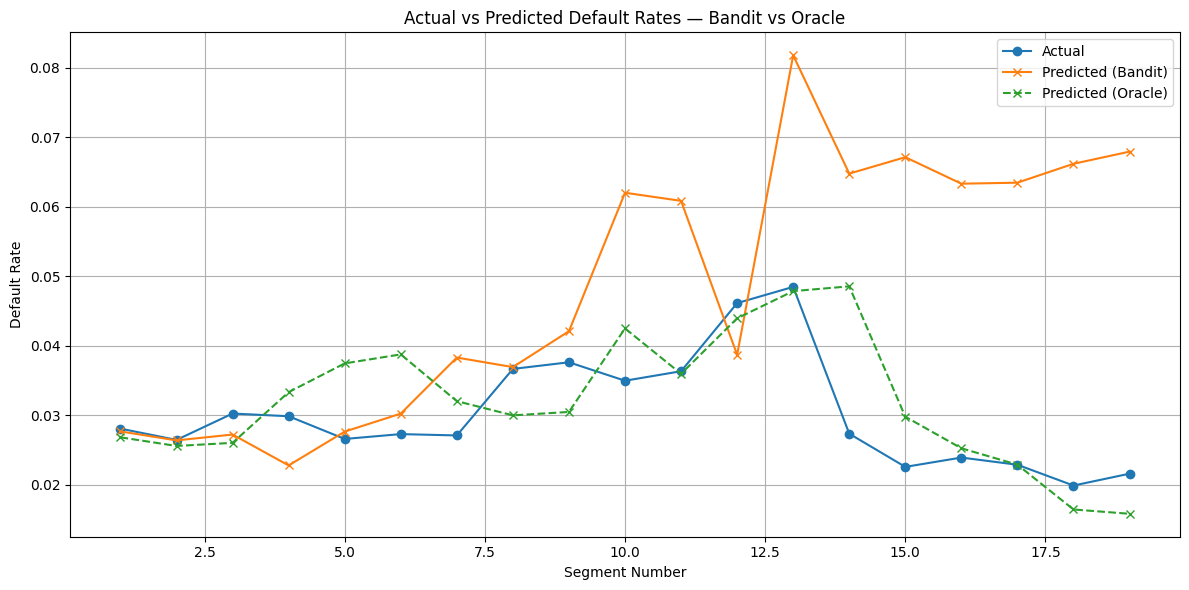

In [ ]:
import matplotlib.pyplot as plt

df_bandit = results_df[results_df["type"] == "bandit"].sort_values("segment_num")
df_oracle = results_df[results_df["type"] == "oracle"].sort_values("segment_num")
plt.figure(figsize=(12, 6))

plt.plot(df_bandit["segment_num"], df_bandit["actual_default_rate"], label="Actual", marker='o')
plt.plot(df_bandit["segment_num"], df_bandit["predicted_default_rate"], label="Predicted (Bandit)", marker='x')
plt.plot(df_oracle["segment_num"], df_oracle["predicted_default_rate"], label="Predicted (Oracle)", marker='x', linestyle='--')

plt.xlabel("Segment Number")
plt.ylabel("Default Rate")
plt.title("Actual vs Predicted Default Rates — Bandit vs Oracle")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('../Figures/plot5.pdf', format='pdf')
plt.show()

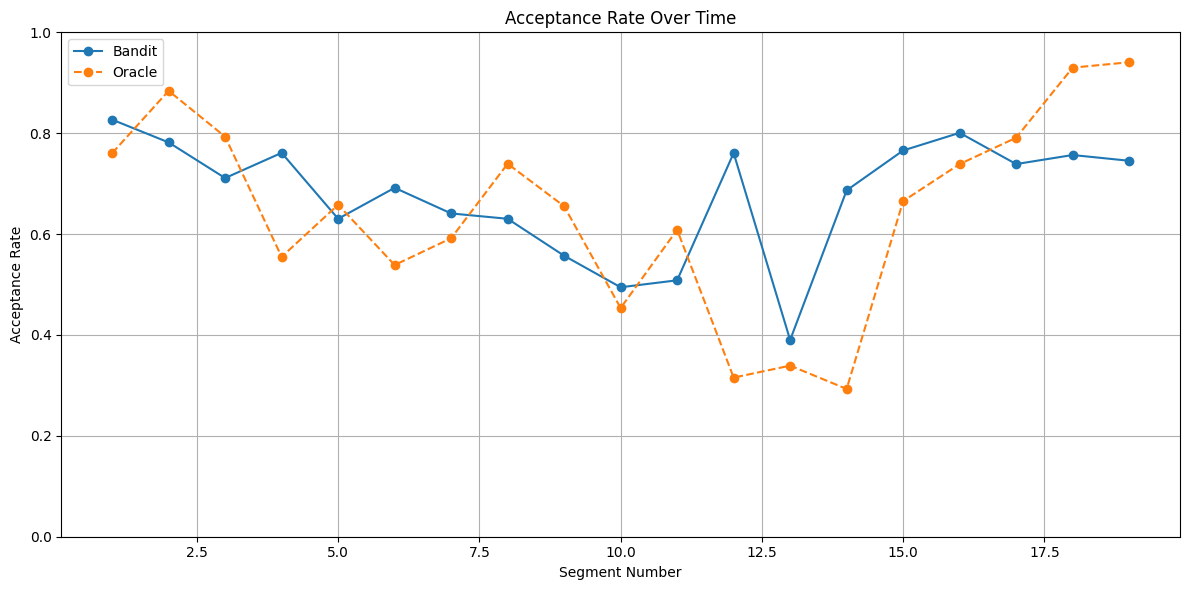

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(df_bandit["segment_num"], df_bandit["accept_rate"], label="Bandit", marker='o')
plt.plot(df_oracle["segment_num"], df_oracle["accept_rate"], label="Oracle", marker='o', linestyle='--')

plt.title("Acceptance Rate Over Time")
plt.xlabel("Segment Number")
plt.ylabel("Acceptance Rate")
plt.ylim(0, 1)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

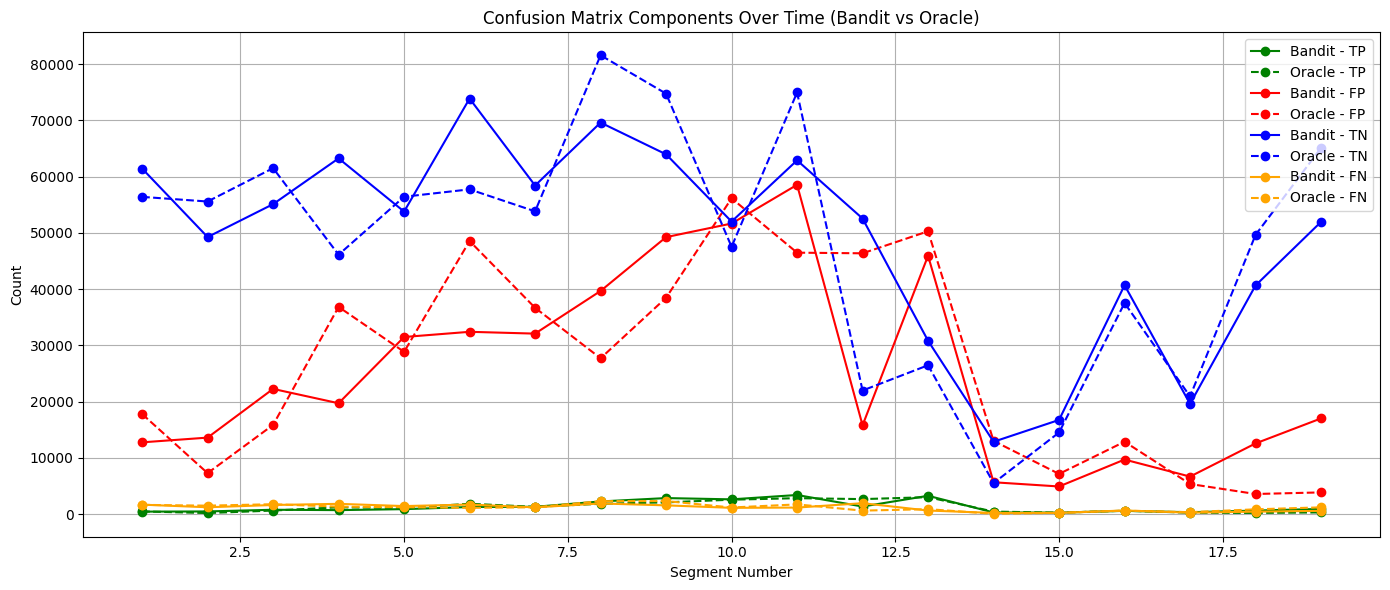

In [ ]:
plt.figure(figsize=(14, 6))
metrics = ["tp", "fp", "tn", "fn"]
colors = ["green", "red", "blue", "orange"]
styles = {"bandit": "-", "oracle": "--"}

for metric, color in zip(metrics, colors):
    for model_type in ["bandit", "oracle"]:
        df = results_df[results_df["type"] == model_type]
        label = f"{model_type.capitalize()} - {metric.upper()}"
        plt.plot(
            df["segment_num"],
            df[metric],
            linestyle=styles[model_type],
            color=color,
            marker='o',
            label=label
        )

plt.title("Confusion Matrix Components Over Time (Bandit vs Oracle)")
plt.xlabel("Segment Number")
plt.ylabel("Count")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
results_df

,segment,segment_num,type,auc,recall,specificity,actual_default_rate,predicted_default_rate,accept_rate,tn,fp,fn,tp
0,split_1,1,bandit,0.475615,0.210084,0.827954,0.028058,0.027657,0.826887,61435,12766,1692,450
1,split_1,1,oracle,0.458247,0.228291,0.760084,0.028058,0.026807,0.760410,56399,17802,1653,489
2,split_2,2,bandit,0.530646,0.282953,0.783536,0.026436,0.026368,0.781778,49257,13608,1224,483
3,split_2,2,oracle,0.446963,0.114236,0.884005,0.026436,0.025564,0.884052,55573,7292,1512,195
4,split_3,3,bandit,0.518444,0.324627,0.712227,0.030232,0.027206,0.711113,55105,22265,1629,783
5,split_3,3,oracle,0.541130,0.266169,0.794933,0.030232,0.026014,0.793086,61504,15866,1770,642
6,split_4,4,bandit,0.515711,0.280956,0.762355,0.029844,0.022763,0.761063,63245,19715,1835,717
7,split_4,4,oracle,0.514518,0.478840,0.555894,0.029844,0.033312,0.554858,46117,36843,1330,1222
8,split_5,5,bandit,0.474576,0.382732,0.630720,0.026575,0.027633,0.630362,53784,31490,1437,891
9,split_5,5,oracle,0.590761,0.468213,0.661655,0.026575,0.037452,0.658204,56422,28852,1238,1090


# Threshold 

In [46]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, recall_score, confusion_matrix

# utility function 
def utility(tp, tn, fp, fn):
    #return tp * 5000 + tn * 100 - fp * 200 - fn * 500
    return tp * 10000 + tn * 500 - fp * 200 - fn * 5000

def run_oracle_with_utility_threshold(final_segments, n_previous_splits=1, thresholds=np.linspace(0.01, 0.3, 40)):
    results = []
    exclude_cols = {'case_id', 'WEEK_NUM', 'target'}
    features = [col for col in final_segments['split_0'].columns if col not in exclude_cols]
    sorted_keys = sorted(final_segments.keys(), key=lambda x: int(x.split('_')[-1]))

    for t in range(n_previous_splits, len(sorted_keys)):
        train_keys = sorted_keys[t - n_previous_splits:t]
        test_key = sorted_keys[t]

        # Combine training data
        X_train = pd.concat([final_segments[k][features] for k in train_keys], ignore_index=True)
        y_train = pd.concat([final_segments[k]['target'] for k in train_keys], ignore_index=True)

        # Test data
        test_segment = final_segments[test_key]
        X_test = test_segment[features]
        y_test = test_segment["target"]

        # Fit model
        model = make_pipeline(StandardScaler(), LogisticRegression(max_iter=1000))
        model.fit(X_train, y_train)

        # Predict probabilities
        y_proba = model.predict_proba(X_test)[:, 1]

        # Find threshold with highest utility
        best_util = -np.inf
        best_threshold = None
        best_stats = {}

        for th in thresholds:
            y_pred = (y_proba >= th).astype(int)
            tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
            util = utility(tp, tn, fp, fn)
            if util > best_util:
                best_util = util
                best_threshold = th
                best_stats = {'tp': tp, 'tn': tn, 'fp': fp, 'fn': fn}

        # Compute final metrics
        tp = best_stats['tp']
        tn = best_stats['tn']
        fp = best_stats['fp']
        fn = best_stats['fn']
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0
        specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
        auc = roc_auc_score(y_test, y_proba)
        accept_rate = (y_proba < best_threshold).mean()

        results.append({
            "segment": test_key,
            "segment_num": int(test_key.split("_")[1]),
            "type": f"oracle_util_{n_previous_splits}splits",
            "threshold": best_threshold,
            "utility": best_util,
            "auc": auc,
            "recall": recall,
            "specificity": specificity,
            "actual_default_rate": y_test.mean(),
            "predicted_default_rate": y_proba.mean(),
            "accept_rate": accept_rate,
            "tn": tn,
            "fp": fp,
            "fn": fn,
            "tp": tp
        })

    return pd.DataFrame(results)


In [25]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, confusion_matrix

def utility(tp, tn, fp, fn):
    #return tp * 10 + tn * 50 - fp * 200 - fn * 5000
    return 50*tp - 100*fn - fp * 5

def run_oracle_with_utility_threshold(final_segments, n_previous_splits=1, thresholds=np.linspace(0.01, 0.3, 40)):
    results = []
    exclude_cols = {'case_id', 'WEEK_NUM', 'target'}
    features = [col for col in final_segments['split_0'].columns if col not in exclude_cols]
    sorted_keys = sorted(final_segments.keys(), key=lambda x: int(x.split('_')[-1]))

    for t in range(n_previous_splits, len(sorted_keys)):
        train_keys = sorted_keys[t - n_previous_splits:t]
        test_key = sorted_keys[t]

        # Prepare training data
        X_train = pd.concat([final_segments[k][features] for k in train_keys], ignore_index=True)
        y_train = pd.concat([final_segments[k]['target'] for k in train_keys], ignore_index=True)

        # Prepare test data
        X_test = final_segments[test_key][features]
        y_test = final_segments[test_key]['target']

        # Train model
        model = make_pipeline(StandardScaler(), LogisticRegression(max_iter=1000))
        model.fit(X_train, y_train)

        # Learn best threshold from training set
        y_train_proba = model.predict_proba(X_train)[:, 1]
        best_util = -np.inf
        best_threshold = None 

        for th in thresholds:
            y_train_pred = (y_train_proba >= th).astype(int)
            tn_, fp_, fn_, tp_ = confusion_matrix(y_train, y_train_pred).ravel()
            trial_util = utility(tp_, tn_, fp_, fn_)
            if trial_util > best_util:
                best_util = trial_util
                best_threshold = th


        th = best_threshold

        # Predict on test set using chosen threshold
        y_test_proba = model.predict_proba(X_test)[:, 1]
        y_test_pred = (y_test_proba >= th).astype(int)
        tn, fp, fn, tp = confusion_matrix(y_test, y_test_pred).ravel()

        # Compute metrics
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0
        specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
        auc = roc_auc_score(y_test, y_test_proba)
        accept_rate = (y_test_proba < th).mean()

        # Store results
        results.append({
            "segment": test_key,
            "segment_num": int(test_key.split("_")[1]),
            "type": f"realistic_util_{n_previous_splits}splits",
            "threshold": th,
            "utility": utility(tp, tn, fp, fn),
            "auc": auc,
            "recall": recall,
            "specificity": specificity,
            "actual_default_rate": y_test.mean(),
            "predicted_default_rate": y_test_proba.mean(),
            "accept_rate": accept_rate,
            "tn": tn,
            "fp": fp,
            "fn": fn,
            "tp": tp
        })

    return pd.DataFrame(results)



In [26]:
oracle_df = run_oracle_with_utility_threshold(final_segments, n_previous_splits=1)


In [27]:
oracle_df

,segment,segment_num,type,threshold,utility,auc,recall,specificity,actual_default_rate,predicted_default_rate,accept_rate,tn,fp,fn,tp
0,split_1,1,realistic_util_1splits,0.024872,-70765,0.634176,0.492081,0.708777,0.026322,0.023143,0.703490,23177,9523,449,435
1,split_2,2,realistic_util_1splits,0.032308,-66230,0.632999,0.342787,0.813894,0.027358,0.025694,0.809607,23467,5366,533,278
2,split_3,3,realistic_util_1splits,0.032308,-109770,0.619091,0.388430,0.760977,0.028502,0.032885,0.756719,34524,10844,814,517
3,split_4,4,realistic_util_1splits,0.032308,-71995,0.601970,0.336818,0.807277,0.027450,0.024978,0.803322,24626,5879,571,290
4,split_5,5,realistic_util_1splits,0.032308,-72305,0.623534,0.387707,0.771910,0.025477,0.026774,0.767843,24979,7381,518,328
5,split_6,6,realistic_util_1splits,0.032308,-113320,0.612833,0.425191,0.752949,0.028155,0.027765,0.747933,37347,12254,826,611
6,split_7,7,realistic_util_1splits,0.032308,-67300,0.645381,0.466667,0.725953,0.033920,0.029287,0.719420,20159,7610,520,455
7,split_8,8,realistic_util_1splits,0.032308,-67300,0.630775,0.604847,0.581754,0.032811,0.034800,0.575632,16274,11700,375,574
8,split_9,9,realistic_util_1splits,0.032308,-133900,0.608759,0.374298,0.768668,0.028327,0.024568,0.764619,42266,12720,1003,600
9,split_10,10,realistic_util_1splits,0.032308,-95615,0.649929,0.386986,0.793139,0.025261,0.026200,0.788589,35746,9323,716,452


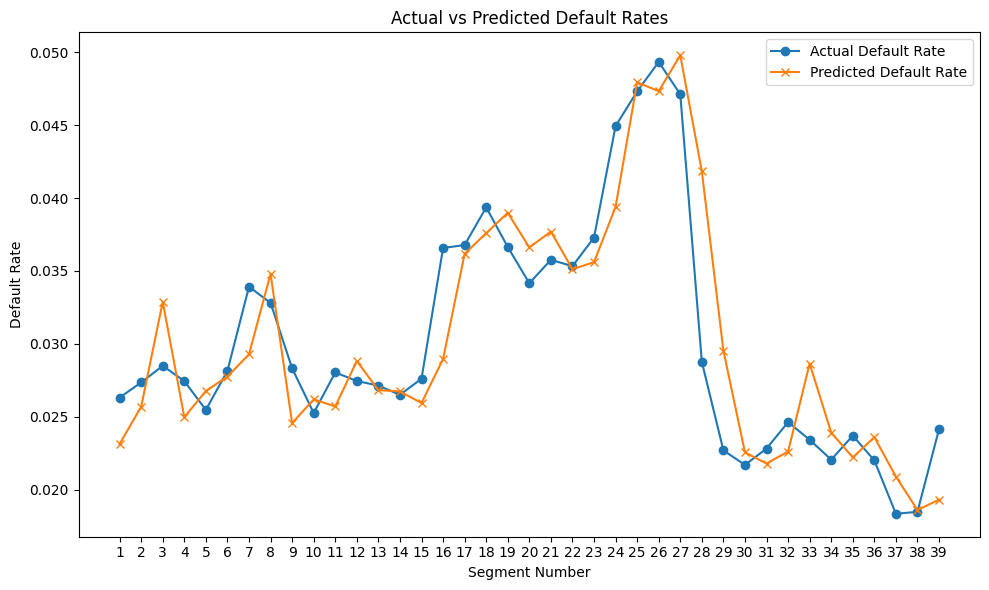

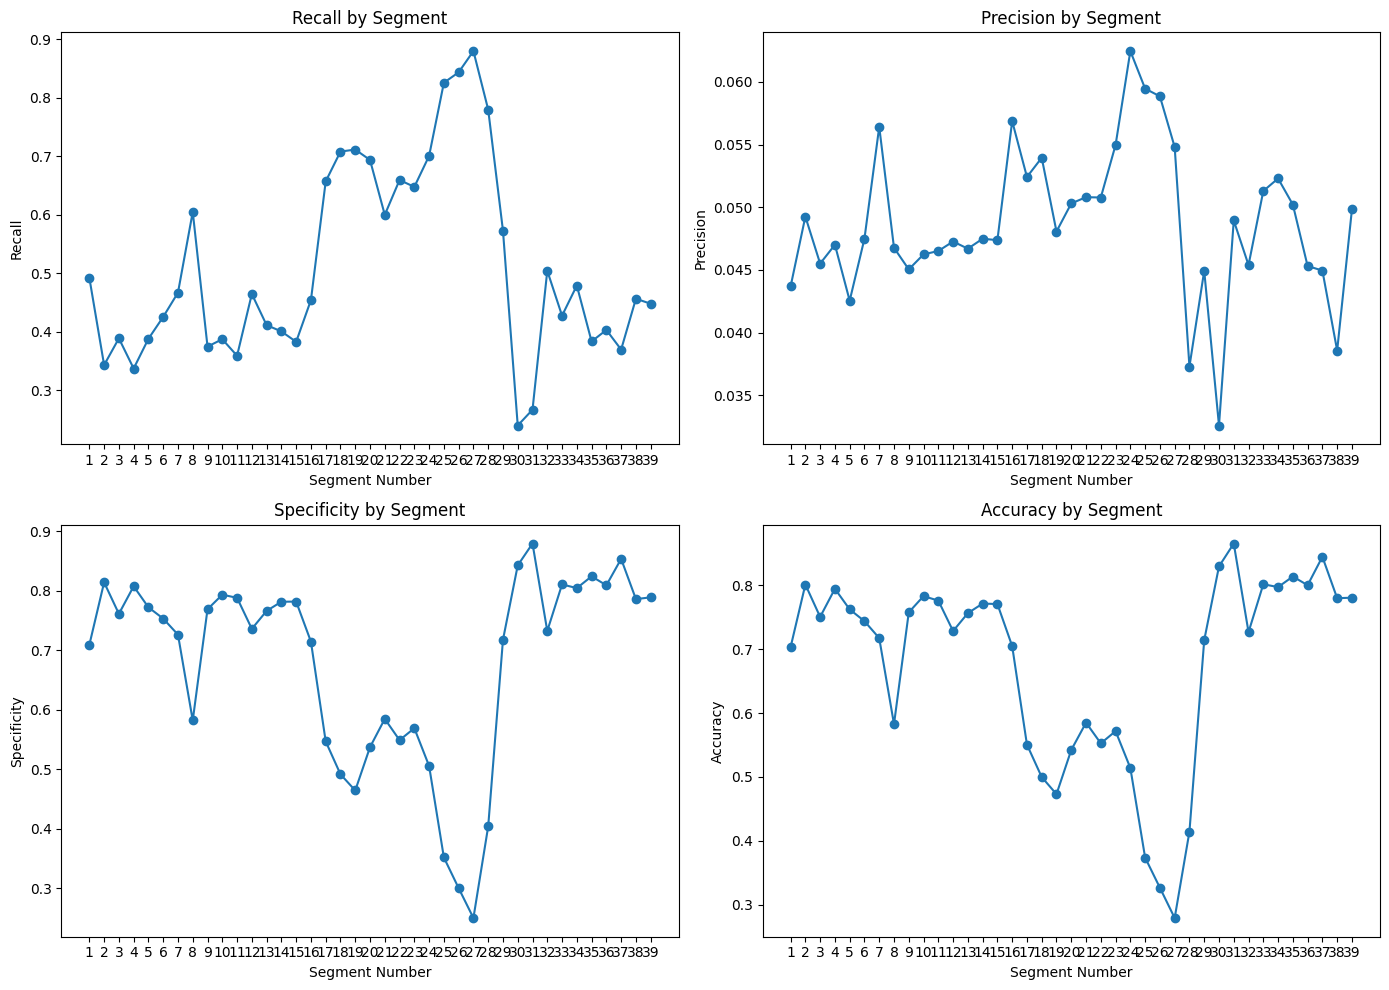

In [28]:
import pandas as pd
import matplotlib.pyplot as plt

oracle_df["accuracy"] = (oracle_df["tp"] + oracle_df["tn"]) / (
    oracle_df["tp"] + oracle_df["tn"] + oracle_df["fp"] + oracle_df["fn"]
)
oracle_df["precision"] = oracle_df["tp"] / (oracle_df["tp"] + oracle_df["fp"])

# Sort by segment_num for consistent x-axis
oracle_df = oracle_df.sort_values("segment_num")

# Plot 1: Actual vs Predicted Default Rates
plt.figure(figsize=(10, 6))
plt.plot(oracle_df["segment_num"], oracle_df["actual_default_rate"], marker='o', label="Actual Default Rate")
plt.plot(oracle_df["segment_num"], oracle_df["predicted_default_rate"], marker='x', label="Predicted Default Rate")
plt.title("Actual vs Predicted Default Rates")
plt.xlabel("Segment Number")
plt.ylabel("Default Rate")
plt.xticks(oracle_df["segment_num"])
plt.legend()
plt.tight_layout()
plt.show()

# Plot 2: Grid of 4 metrics (Recall, Precision, Specificity, Accuracy)
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

metrics = ["recall", "precision", "specificity", "accuracy"]
titles = ["Recall by Segment", "Precision by Segment", "Specificity by Segment", "Accuracy by Segment"]

for ax, metric, title in zip(axes.flatten(), metrics, titles):
    ax.plot(oracle_df["segment_num"], oracle_df[metric], marker='o')
    ax.set_title(title)
    ax.set_xlabel("Segment Number")
    ax.set_ylabel(metric.capitalize())
    ax.set_xticks(oracle_df["segment_num"])

plt.tight_layout()
plt.show()



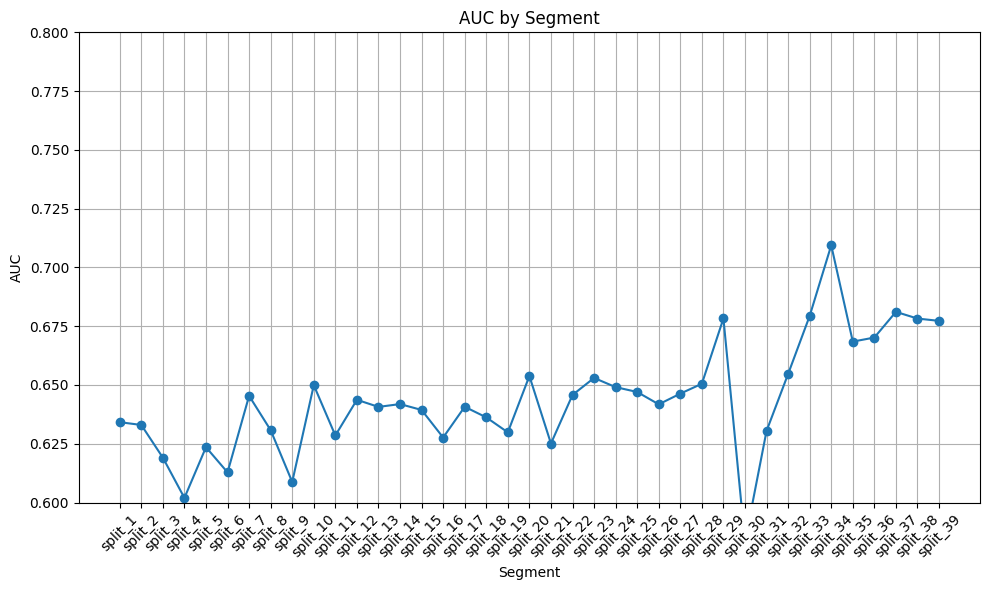

In [29]:
plt.figure(figsize=(10, 6))
plt.plot(oracle_df["segment"], oracle_df["auc"], marker='o')
plt.title("AUC by Segment")
plt.xlabel("Segment")
plt.ylabel("AUC")
plt.ylim(0.6, .8)
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()